# Lake Washington Wetland MAG Analysis
**Zach Flinkstrom** \
\
**Notebook Outline:**
* Load information about MAG set (metadata, read mapping, taxonomy)
* Plot basic stats about MAG quality
* Analyze MAG abundance over seasons and depths
* Summarize MAG abundance and stats per phylum
* Look at MAG functional potential using DRAM annotations

In [1]:
#load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import anndata
from statsmodels.stats.multitest import fdrcorrection
from scikit_posthocs import posthoc_dunn
from scipy.stats import chisquare, fisher_exact, spearmanr, normaltest, norm
from textwrap import wrap
import json

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Load in MAG data (metadata, read mapping, taxonomy, etc.)

In [2]:
#Load file name mapping information
filename_map = pd.read_excel('data/MAGs/filename_mapping.xlsx')
filename_map['sample_name'] = filename_map.Season+'_'+filename_map.Core+'_'+filename_map.Depth
filename_map.head()

,File_name,Season,Core,Depth,sample_name
0,52662.2.414607.AACTGAGC-AACTGAGC.filter-METAGE...,LW1,C3,Top,LW1_C3_Top
1,52662.2.414607.ACCTAAGG-ACCTAAGG.filter-METAGE...,LW1,C2,Top,LW1_C2_Top
2,52662.2.414607.CCTTGTAG-CCTTGTAG.filter-METAGE...,LW1,C3,Mid,LW1_C3_Mid
3,52662.2.414607.CGGCTAAT-CGGCTAAT.filter-METAGE...,LW1,C4,Mid,LW1_C4_Mid
4,52662.2.414607.CTTGGATG-CTTGGATG.filter-METAGE...,LW1,C4,Top,LW1_C4_Top


In [3]:
#Load read mapping abundance data from coverm analysis
coverm = pd.read_excel('data/MAGs/coverm.xlsx', index_col=0)
coverm.rename(dict(zip(filename_map.File_name, filename_map.sample_name)), axis=1, inplace=True)
coverm.drop('unmapped', inplace=True)
coverm = coverm.loc[coverm.max(axis=1) > 0] #drops any genomes without mapped reads
coverm = coverm.T.sort_index()
coverm.head()

Genome,3300060478_1093,3300060607_1232,3300055390_609,3300055390_922,3300060478_136,3300055390_1093,3300060478_1076,3300067053_173,3300055390_1054,3300060478_1029,...,3300067053_692,3300067053_1609,3300067053_594,3300067053_1381,3300055390_240,3300060607_439,3300060478_870,3300060607_507,3300055390_915,3300067053_861
LW1_C2_Btm,0.026156,0.011492,0.008375,0.051792,0.014748,0.019426,0.048548,0.029364,0.044049,0.009568,...,0.125435,0.077456,0.023772,0.000000,0.000000,0.000000,0.154151,0.000000,0.053965,0.000000
LW1_C2_Mid,0.038133,0.006272,0.164682,0.064505,0.015483,0.039772,0.019944,0.044383,0.069289,0.046436,...,0.093405,0.090340,0.029389,0.000000,0.005433,0.000000,0.072304,0.005396,0.069799,0.000000
LW1_C2_Top,0.051797,0.009498,0.024015,0.096953,0.011203,0.057213,0.002308,0.028798,0.082208,0.033788,...,0.018089,0.034033,0.036235,0.003228,0.010190,0.000000,0.015209,0.023097,0.025196,0.015026
LW1_C3_Btm,0.069224,0.010067,0.005232,0.111547,0.009107,0.041010,0.000000,0.034769,0.035879,0.023566,...,0.007845,0.009670,0.023288,0.010772,0.008976,0.006154,0.004942,0.010394,0.009662,0.022649
LW1_C3_Mid,0.081543,0.011971,0.002799,0.103538,0.007909,0.031714,0.000000,0.041323,0.013541,0.016966,...,0.005235,0.008278,0.013249,0.030129,0.006472,0.005469,0.001792,0.003950,0.004034,0.017259


In [4]:
#Add metadata columns for sample season, depth, and core
month_mapper = {'LW1':'Oct', 'LW2':'Feb', 'LW3':'May', 'LW4':'Aug'} #maps sampling campaign code to month
core_mapper = {'Top':10, 'Mid':30, 'Btm':50}
name_list = [i.split()[-1].split('_') for i in coverm.index] #breaks down into sampling campaign, core#, depth
month_list = [month_mapper[i[0]] for i in name_list]
core_list = [i[1] for i in name_list]
depth_list = [i[2] for i in name_list]
depth_cm_list = [core_mapper[i[2]] for i in name_list]

obs_df = pd.DataFrame(np.array([month_list, core_list, depth_list, depth_cm_list]).T, 
                          index=coverm.index, columns=['Month', 'Core', 'Depth', 'Depth_cm'])
obs_df.head()

,Month,Core,Depth,Depth_cm
LW1_C2_Btm,Oct,C2,Btm,50
LW1_C2_Mid,Oct,C2,Mid,30
LW1_C2_Top,Oct,C2,Top,10
LW1_C3_Btm,Oct,C3,Btm,50
LW1_C3_Mid,Oct,C3,Mid,30


In [5]:
#Load GTDB bacteria classifications
bacteria = pd.read_csv('data/MAGs/gtdb_bacteria.csv')
bacteria['Genome'] = bacteria['User Genome'].str.split('__', expand=True)[0]
bacteria.set_index('Genome', inplace=True)
#Load GTDB archaea classifications
archaea = pd.read_csv('data/MAGs/gtdb_archaea.csv')
archaea['Genome'] = archaea['User Genome'].str.split('__', expand=True)[0]
archaea.set_index('Genome', inplace=True)
#Concatenate bacteria and archaea classifications
bacteria_archaea = pd.concat([bacteria, archaea])
taxonomy = bacteria_archaea['Classification'].str.split(';', expand=True)
taxonomy.rename({0:'domain', 1:'phylum', 2:'class', 3:'order', 4:'family', 5:'genus', 6:'species'}, axis=1, inplace=True)
bacteria_archaea = bacteria_archaea.merge(taxonomy, left_index=True, right_index=True)
bacteria_archaea

,User Genome,Classification,FastANI Reference,FastANI Reference Radius,FastANI Taxonomy,FastANI ANI,FastANI Alignment Fraction,Closest Placement Reference,Closest Placement Taxonomy,Closest Placement ANI,...,MSA AA Percent,RED Value,Warnings,domain,phylum,class,order,family,genus,species
Genome,,,,,,,,,,,,,,,,,,,,,
3300055390_1033,3300055390_1033__dereplicated_genomes,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,-,-,-,-,-,-,-,-,...,90.69,0.94557,Genome not assigned to closest species as it f...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Thiobacillaceae,g__UBA6918,s__
3300055390_1034,3300055390_1034__dereplicated_genomes,d__Bacteria;p__Myxococcota;c__Polyangia;o__Pol...,-,-,-,-,-,-,-,-,...,90.63,0.83489,-,d__Bacteria,p__Myxococcota,c__Polyangia,o__Polyangiales,f__JAFGIB01,g__,s__
3300055390_1041,3300055390_1041__dereplicated_genomes,d__Bacteria;p__Fermentibacterota;c__Fermentiba...,-,-,-,-,-,GCA_002414865.1,d__Bacteria;p__Fermentibacterota;c__Fermentiba...,77.85,...,87.71,0.85532,-,d__Bacteria,p__Fermentibacterota,c__Fermentibacteria,o__Fermentibacterales,f__Fermentibacteraceae,g__UBA5938,s__
3300055390_1045,3300055390_1045__dereplicated_genomes,d__Bacteria;p__Zixibacteria;c__MSB-5A5;o__MSB-...,-,-,-,-,-,-,-,-,...,91.14,0.61281,-,d__Bacteria,p__Zixibacteria,c__MSB-5A5,o__MSB-5A5,f__,g__,s__
3300055390_1047,3300055390_1047__dereplicated_genomes,d__Bacteria;p__Eisenbacteria;c__RBG-16-71-46;o...,-,-,-,-,-,-,-,-,...,81.37,0.62407,-,d__Bacteria,p__Eisenbacteria,c__RBG-16-71-46,o__RBG-16-71-46,f__,g__,s__
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300067053_462,3300067053_462__dereplicated_genomes,d__Archaea;p__Halobacteriota;c__Methanomicrobi...,-,-,-,-,-,GCA_002495055.1,d__Archaea;p__Halobacteriota;c__Methanomicrobi...,83.29,...,55.36,0.97948,Genome not assigned to closest species as it f...,d__Archaea,p__Halobacteriota,c__Methanomicrobia,o__Methanomicrobiales,f__Methanoregulaceae,g__Methanoregula,s__
3300067053_621,3300067053_621__dereplicated_genomes,d__Archaea;p__Halobacteriota;c__Methanosarcini...,-,-,-,-,-,-,-,-,...,86.25,0.93049,-,d__Archaea,p__Halobacteriota,c__Methanosarcinia,o__Methanosarcinales,f__Methanoperedenaceae,g__Methanoperedens,s__
3300067053_692,3300067053_692__dereplicated_genomes,d__Archaea;p__Halobacteriota;c__Methanosarcini...,-,-,-,-,-,GCA_013178225.1,d__Archaea;p__Halobacteriota;c__Methanosarcini...,77.35,...,92.26,0.86035,-,d__Archaea,p__Halobacteriota,c__Methanosarcinia,o__Methanotrichales,f__Methanotrichaceae,g__JABLXE01,s__


In [6]:
# Load in CheckM summary info
checkm = pd.read_csv('data/MAGs/CheckM_summary_table.tsv', sep='\t')
checkm['Genome'] = checkm['Bin Name'].str.split('__', expand=True)[0]
checkm.set_index('Genome', inplace=True)
checkm

,Bin Name,Marker Lineage,# Genomes,# Markers,# Marker Sets,0,1,2,3,4,5+,Completeness,Contamination
Genome,,,,,,,,,,,,,
3300055390_1033,3300055390_1033__dereplicated_genomes,c__Betaproteobacteria,235,419,211,27,391,1,0,0,0,96.45,0.47
3300055390_1034,3300055390_1034__dereplicated_genomes,c__Deltaproteobacteria,83,247,155,9,236,2,0,0,0,94.19,1.29
3300055390_1041,3300055390_1041__dereplicated_genomes,k__Bacteria,2993,147,91,5,141,1,0,0,0,96.15,1.10
3300055390_1045,3300055390_1045__dereplicated_genomes,k__Bacteria,2993,147,91,1,143,3,0,0,0,98.90,3.30
3300055390_1047,3300055390_1047__dereplicated_genomes,k__Bacteria,2993,147,91,26,119,2,0,0,0,90.64,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300067053_951,3300067053_951__dereplicated_genomes,k__Archaea,207,149,107,45,97,7,0,0,0,75.29,4.67
3300067053_955,3300067053_955__dereplicated_genomes,c__Spirochaetia,72,215,125,14,193,8,0,0,0,93.20,4.40
3300067053_962,3300067053_962__dereplicated_genomes,c__Deltaproteobacteria,83,247,155,15,228,4,0,0,0,96.32,2.26


In [7]:
# Load in the rest of the bin stats
tmp = pd.read_csv('data/MAGs/bin_stats.analyze.tsv', sep='\t', names=['Genome','data'])
for i, name in enumerate(tmp.Genome):
    if i == 0:
        checkm2 = pd.DataFrame(json.loads(tmp.iloc[i,1].replace("'", '"')), index=[name.split('__')[0]])
    else:
        checkm2 = pd.concat([checkm2, pd.DataFrame(json.loads(tmp.iloc[i,1].replace("'", '"')), index=[name.split('__')[0]])])
checkm2

,Translation table,GC std,# ambiguous bases,Genome size,Longest contig,N50 (scaffolds),Mean scaffold length,# contigs,# scaffolds,# predicted genes,Longest scaffold,GC,N50 (contigs),Coding density,Mean contig length
3300055390_1033,11,0.028631,0,2532618,278748,103377,52762.875000,48,48,2564,278748,0.603988,103377,0.915751,52762.875000
3300055390_1041,11,0.013059,0,2452056,217973,72316,30272.296296,81,81,2288,217973,0.648763,72316,0.932221,30272.296296
3300055390_1045,11,0.012674,0,2729923,103891,39297,25045.165138,109,109,2450,103891,0.391512,39297,0.887176,25045.165138
3300055390_1048,11,0.014189,0,1952533,138492,53193,27893.328571,70,70,1986,138492,0.576858,53193,0.930955,27893.328571
3300055390_1047,11,0.021820,0,3135331,90846,19251,13009.672199,241,241,2687,90846,0.720219,19251,0.908963,13009.672199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300067053_955,11,0.026065,0,3172021,60007,17784,14418.277273,220,220,2848,60007,0.584356,17784,0.916035,14418.277273
3300067053_962,11,0.022492,0,3840352,127022,56266,36574.780952,105,105,3380,127022,0.532088,56266,0.906374,36574.780952
3300067053_951,11,0.021251,0,6149691,66244,19384,14642.121429,420,420,5753,66244,0.496450,19384,0.906497,14642.121429
3300067053_967,11,0.037235,0,4254909,25747,6703,6175.484761,689,689,4294,25747,0.590022,6703,0.879027,6175.484761


In [8]:
# Merge all bin stats together
checkm = checkm.merge(checkm2, left_index=True, right_index=True)

#Add genome stats to metadata table
bacteria_archaea = bacteria_archaea.merge(checkm, left_index=True, right_index=True)

# remove bins that did not have any mapped reads by coverM
var_df = bacteria_archaea.loc[coverm.columns]

# Create AnnData object containing coverM abundance data with info about bin stats and sample metadata
ad = anndata.AnnData(X=coverm, obs=obs_df, var=var_df)
ad

AnnData object with n_obs × n_vars = 36 × 428
    obs: 'Month', 'Core', 'Depth', 'Depth_cm'
    var: 'User Genome', 'Classification', 'FastANI Reference', 'FastANI Reference Radius', 'FastANI Taxonomy', 'FastANI ANI', 'FastANI Alignment Fraction', 'Closest Placement Reference', 'Closest Placement Taxonomy', 'Closest Placement ANI', 'Closest Placement Alignment Fraction', 'Classification Method', 'Note', 'Other Related References', 'MSA AA Percent', 'RED Value', 'Warnings', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'Bin Name', 'Marker Lineage', '# Genomes', '# Markers', '# Marker Sets', '0', '1', '2', '3', '4', '5+', 'Completeness', 'Contamination', 'Translation table', 'GC std', '# ambiguous bases', 'Genome size', 'Longest contig', 'N50 (scaffolds)', 'Mean scaffold length', '# contigs', '# scaffolds', '# predicted genes', 'Longest scaffold', 'GC', 'N50 (contigs)', 'Coding density', 'Mean contig length'

## Plot basic MAG statistics

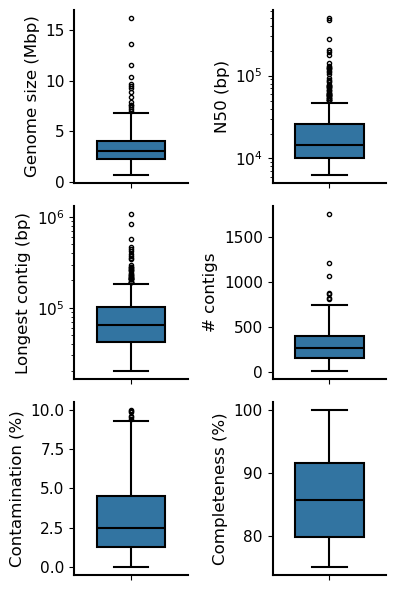

In [9]:
# Plot basic MAG statistics
ad.var['Genome size (Mbp)'] = ad.var['Genome size']/1e6
fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axe in ax.flat:
    axe.tick_params(axis='both', which='major', labelsize=11)
    axe.spines['left'].set_linewidth(1.5)
    axe.spines['bottom'].set_linewidth(1.5)

sns.despine()
sns.boxplot(data=ad.var, y='Genome size (Mbp)', ax=ax[0,0], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[0,0].set_ylabel('Genome size (Mbp)', size=12)
sns.boxplot(data=ad.var, y='N50 (scaffolds)', ax=ax[0,1], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[0,1].set_ylabel('N50 (bp)', size=12)
ax[0,1].set(yscale="log")
sns.boxplot(data=ad.var, y='Longest contig', ax=ax[1,0], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[1,0].set_ylabel('Longest contig (bp)', size=12)
ax[1,0].set(yscale="log")
sns.boxplot(data=ad.var, y='# contigs', ax=ax[1,1], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[1,1].set_ylabel('# contigs', size=12)
sns.boxplot(data=ad.var, y='Contamination', ax=ax[2,0], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[2,0].set_ylabel('Contamination (%)', size=12)
sns.boxplot(data=ad.var, y='Completeness', ax=ax[2,1], width=.6, fliersize=3, linewidth=1.5, linecolor='black')
ax[2,1].set_ylabel('Completeness (%)', size=12)

plt.tight_layout()
plt.savefig('figures/MAG_stats.png', dpi=450, bbox_inches='tight')
plt.show()

In [10]:
print('Mean +/- std:')
print('Mean genome size (Mbp) = '+"%0.2f" % ad.var['Genome size (Mbp)'].mean()+' +/- '+"%0.2f" % ad.var['Genome size (Mbp)'].std())
print('Mean N50 (bp) = '+"%0.2f" % ad.var['N50 (scaffolds)'].mean()+' +/- '+"%0.2f" % ad.var['N50 (scaffolds)'].std())

print('Mean Longest contig (bp) = '+"%0.2f" % ad.var['Longest contig'].mean()+' +/- '+"%0.2f" % ad.var['Longest contig'].std())
print('Mean # contigs = '+"%0.2f" % ad.var['# contigs'].mean()+' +/- '+"%0.2f" % ad.var['# contigs'].std())

print('Mean Contamination (%) = '+"%0.2f" % ad.var['Contamination'].mean()+' +/- '+"%0.2f" % ad.var['Contamination'].std())
print('Mean Completeness (%) = '+"%0.2f" % ad.var['Completeness'].mean()+' +/- '+"%0.2f" % ad.var['Completeness'].std())

Mean +/- std:
Mean genome size (Mbp) = 3.38 +/- 1.82
Mean N50 (bp) = 26332.39 +/- 42186.36
Mean Longest contig (bp) = 89538.14 +/- 92733.32
Mean # contigs = 289.08 +/- 194.09
Mean Contamination (%) = 3.09 +/- 2.33
Mean Completeness (%) = 86.02 +/- 6.90


## Compute statistics for MAG relative abundance over seasons and depths

In [11]:
# Compute ANOVA-like Kruskal test for each MAGs abundance over depth and season.
# Also compute Spearman correlation for each MAGs abundance vs depth
season_pvals = []
depth_pvals = []
depth_r = []
depth_r_p = []
for i in range(len(ad.var.index)):
    season_temp = stats.kruskal(ad[ad.obs.Month == 'Oct'].X[:,i], 
                                ad[ad.obs.Month == 'Feb'].X[:,i], 
                                ad[ad.obs.Month == 'May'].X[:,i], 
                                ad[ad.obs.Month == 'Aug'].X[:,i]).pvalue
    depth_temp = stats.kruskal(ad[ad.obs.Depth == 'Top'].X[:,i], 
                                ad[ad.obs.Depth == 'Mid'].X[:,i], 
                                ad[ad.obs.Depth == 'Btm'].X[:,i]).pvalue
    depth_spearman = stats.spearmanr(ad.obs.Depth_cm, ad.X[:,i], alternative = 'two-sided')
    season_pvals.append(season_temp)
    depth_pvals.append(depth_temp)
    depth_r.append(depth_spearman.correlation)

In [12]:
# Permutation test for Spearman correlation
# i.e. randomly permute depth label and compute Spearman correlation to get a null distribution
from random import sample
random_r = []
for j in range(100):
    for i in range(len(ad.var.index)):
        random_depths = sample(list(ad.obs.Depth_cm.astype(int)), len(ad.obs.Depth_cm))
        random_r.append(stats.spearmanr(random_depths, ad.X[:,i], alternative = 'two-sided').correlation)

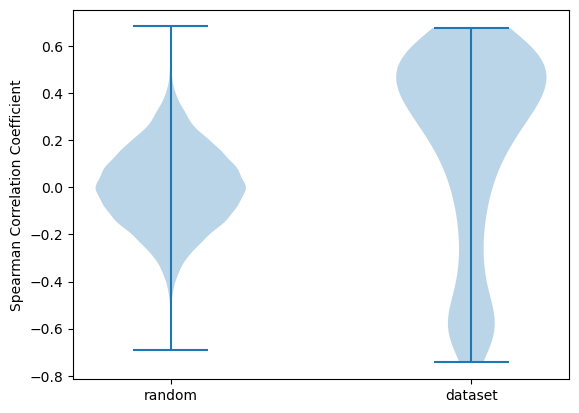

In [13]:
# Plot null distribution next to actual dataset distribution of Spearman correlation coefficients
plt.violinplot([random_r, depth_r])
plt.xticks([1,2],['random', 'dataset'])
plt.ylabel('Spearman Correlation Coefficient')
plt.savefig('figures/spearman_permutation_test.png', dpi=450)
plt.show()

In [14]:
# Print statistics related to null distribution
mu = np.mean(random_r)
sigma = np.std(random_r)
print(normaltest(random_r))
print("mean = " + str(mu))
print("std = " + str(sigma))

NormaltestResult(statistic=np.float64(40.24559310149864), pvalue=np.float64(1.8229740962665698e-09))
mean = -0.0007241207240816751
std = 0.16923159673971677


In [15]:
# Compute probability of actual dataset r values using the random null distribution
z_scores = []
p_vals = []
for i in depth_r:
    z = (i - mu)/sigma
    z_scores.append(z)
    p = norm.sf(abs(z))*2
    p_vals.append(p)

In [16]:
# Append p-values and BH FDR corrected p-values to the adata object
ad.var['kruskal_season_p'] = season_pvals
ad.var['kruskal_season_p_corr'] = fdrcorrection(season_pvals, alpha=0.05)[1]
ad.var['kruskal_depth_p'] = depth_pvals
ad.var['kruskal_depth_p_corr'] = fdrcorrection(depth_pvals, alpha=0.05)[1]
ad.var['spearman_depth_p'] = p_vals
ad.var['spearman_depth_p_corr'] = fdrcorrection(p_vals, alpha=0.05)[1]
ad.var['spearman_depth_r'] = depth_r

In [17]:
ad.var['median_rel_abun'] = np.median(ad.X, axis=0)
ad.var['mean_rel_abun'] = np.mean(ad.X, axis=0)
ad.var['max_rel_abun'] = np.max(ad.X, axis=0)

In [18]:
ad.var.to_csv('output/adata_var.csv') # output adata variable info to csv

## Summarize MAGs by class

In [19]:
# create new column with domain and phylum name
ad.var['class_plus'] = [i[0] for i in ad.var['Classification'].str.split('o__')] 
ad.var

,User Genome,Classification,FastANI Reference,FastANI Reference Radius,FastANI Taxonomy,FastANI ANI,FastANI Alignment Fraction,Closest Placement Reference,Closest Placement Taxonomy,Closest Placement ANI,...,kruskal_season_p_corr,kruskal_depth_p,kruskal_depth_p_corr,spearman_depth_p,spearman_depth_p_corr,spearman_depth_r,median_rel_abun,mean_rel_abun,max_rel_abun,class_plus
Genome,,,,,,,,,,,,,,,,,,,,,
3300060478_1093,3300060478_1093__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Anaerolineae;o...,-,-,-,-,-,-,-,-,...,0.960518,0.004570,0.014351,0.001090,0.003617,-0.553459,0.049323,0.055540,0.113765,d__Bacteria;p__Chloroflexota;c__Anaerolineae;
3300060607_1232,3300060607_1232__dereplicated_genomes,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,-,-,-,-,-,GCA_009377445.1,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,83.4,...,0.157513,0.795943,0.803128,0.532936,0.576001,0.104797,0.011894,0.017107,0.113085,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
3300055390_609,3300055390_609__dereplicated_genomes,d__Bacteria;p__JAGLYR01;c__JAGLYR01;o__;f__;g_...,-,-,-,-,-,-,-,-,...,0.979198,0.072575,0.096612,0.063925,0.090596,0.312812,0.007081,0.013045,0.164682,d__Bacteria;p__JAGLYR01;c__JAGLYR01;
3300055390_922,3300055390_922__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Limnocylindria...,-,-,-,-,-,GCA_021802585.1,d__Bacteria;p__Chloroflexota;c__Limnocylindria...,81.47,...,0.124256,0.179341,0.208581,0.072586,0.099894,-0.304566,0.072966,0.075495,0.139066,d__Bacteria;p__Chloroflexota;c__Limnocylindria;
3300060478_136,3300060478_136__dereplicated_genomes,d__Bacteria;p__Eisenbacteria;c__RBG-16-71-46;o...,-,-,-,-,-,GCA_016223045.1,d__Bacteria;p__Eisenbacteria;c__RBG-16-71-46;o...,79.61,...,0.960518,0.136458,0.164518,0.045771,0.067089,0.337315,0.008882,0.015334,0.191738,d__Bacteria;p__Eisenbacteria;c__RBG-16-71-46;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300060607_439,3300060607_439__dereplicated_genomes,d__Bacteria;p__Desulfobacterota;c__Desulfobulb...,-,-,-,-,-,GCA_004284765.1,d__Bacteria;p__Desulfobacterota;c__Desulfobulb...,92.71,...,0.231616,0.260850,0.287742,0.102541,0.135039,-0.277021,0.000000,0.005510,0.062999,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;
3300060478_870,3300060478_870__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,-,-,-,-,-,-,-,-,...,0.960518,0.000949,0.009602,0.000192,0.002217,0.630394,0.009430,0.031406,0.268268,d__Bacteria;p__Chloroflexota;c__Dehalococcoidia;
3300060607_507,3300060607_507__dereplicated_genomes,d__Archaea;p__Halobacteriota;c__Methanosarcini...,-,-,-,-,-,-,-,-,...,0.824064,0.064193,0.087499,0.055422,0.079867,0.323448,0.007464,0.014933,0.093864,d__Archaea;p__Halobacteriota;c__Methanosarcinia;


In [21]:
# Filter out MAGs with a median relative abundance less than 0.01%
ad = ad[:, np.median(ad.X, axis=0)>0.01]

In [22]:
ad.var.to_csv('output/filtered_ad_var.csv')

In [23]:
# Find the mean MAG relative abundance for each class at each depth
mag_class_abun = {}
for mag_class in set(ad.var['class_plus']):
    tmp = {}
    for depth in ['Top','Mid','Btm']:
        tmp[depth] = np.mean(ad[ad.obs.Depth==depth, ad.var['class_plus']==mag_class].X)
    mag_class_abun[mag_class] = tmp

# convert data into dataframe format
mag_class_abun_df = pd.DataFrame(mag_class_abun).T.sort_index().astype(float)
mag_class_abun_df

,Top,Mid,Btm
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;,0.008763,0.031291,0.028090
d__Archaea;p__Halobacteriota;c__Methanomicrobia;,0.034691,0.057889,0.066601
d__Archaea;p__Halobacteriota;c__Methanosarcinia;,0.016237,0.027881,0.037954
d__Archaea;p__Thermoplasmatota;c__E2;,0.017428,0.038649,0.043817
d__Archaea;p__Thermoplasmatota;c__Themoplasmata_A;,0.014657,0.022855,0.016650
d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;,0.017606,0.030232,0.027494
d__Archaea;p__Thermoproteota;c__Bathyarchaeia;,0.020318,0.034161,0.040430
d__Bacteria;p__4484-113;c__4484-113;,0.006093,0.017411,0.016191
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;,0.028797,0.052900,0.063039
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;,0.032428,0.020072,0.015101


In [24]:
# Find median Spearman correlation coefficient and p-value for each phylum
mag_class_abun_df['spearman_r'] = ad.var.groupby('class_plus')['spearman_depth_r'].median()
#mag_class_abun_df['spearman_r_p'] = ad.var.groupby('class_plus')['spearman_depth_p_corr'].median()
mag_class_abun_df['spearman_r_p'] = ad.var.groupby('class_plus')['spearman_depth_r'].median().map(lambda i: norm.sf(abs((i - mu)/sigma))*2)
# Create a column with annotation levels for p-values (i.e. NS, *, **, or ***)
annot = []
for p in mag_class_abun_df['spearman_r_p']:
    if p >= 0.05: annot.append('NS')
    elif (p < 0.05)&(p>=0.01): annot.append('*')
    elif (p < 0.01)&(p>=0.001): annot.append('**')
    elif p < 0.001: annot.append('***')
        
mag_class_abun_df['pval_annot'] = annot
mag_class_abun_df['class_counts'] = ad.var['class_plus'].value_counts()
mag_class_abun_df

,Top,Mid,Btm,spearman_r,spearman_r_p,pval_annot,class_counts
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;,0.008763,0.031291,0.028090,0.362203,0.031988,*,1
d__Archaea;p__Halobacteriota;c__Methanomicrobia;,0.034691,0.057889,0.066601,0.504336,0.002841,**,9
d__Archaea;p__Halobacteriota;c__Methanosarcinia;,0.016237,0.027881,0.037954,0.451156,0.007581,**,4
d__Archaea;p__Thermoplasmatota;c__E2;,0.017428,0.038649,0.043817,0.397432,0.018636,*,6
d__Archaea;p__Thermoplasmatota;c__Themoplasmata_A;,0.014657,0.022855,0.016650,0.091721,0.584885,NS,1
d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;,0.017606,0.030232,0.027494,0.359362,0.033356,*,2
d__Archaea;p__Thermoproteota;c__Bathyarchaeia;,0.020318,0.034161,0.040430,0.327491,0.052448,NS,6
d__Bacteria;p__4484-113;c__4484-113;,0.006093,0.017411,0.016191,0.446394,0.008241,**,1
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;,0.028797,0.052900,0.063039,0.504498,0.002832,**,10
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;,0.032428,0.020072,0.015101,-0.616079,0.000277,***,3


In [25]:
mag_class_abun_df = mag_class_abun_df.sort_values('spearman_r')

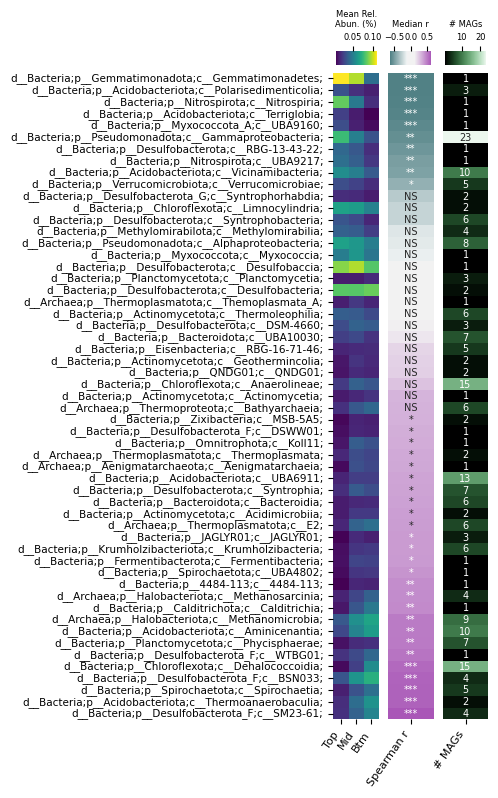

In [27]:
# Plot class summarized abundance, correlation, and number of MAG information
fig, ax = plt.subplots(1,3,figsize=(2,10))
sns.heatmap(mag_class_abun_df.iloc[:,0:3], cmap='viridis', vmax=0.11, ax=ax[0], cbar_kws = dict(use_gridspec=False, location="top", shrink=0.9, pad=0.01, aspect=3.),
           yticklabels=mag_class_abun_df.index, xticklabels=['Top','Mid','Btm'])
sns.heatmap(pd.DataFrame(mag_class_abun_df.iloc[:,3]), cmap=sns.diverging_palette(200, 300, s=60, sep=50, as_cmap=True),
            annot = pd.DataFrame(mag_class_abun_df.iloc[:,5]).astype(str), fmt='', annot_kws={"fontsize":7}, center=0., yticklabels=False, xticklabels=['Spearman r'], ax=ax[1], cbar_kws = dict(use_gridspec=False, location="top", shrink=0.9, pad=0.01, aspect=3.))
sns.heatmap(pd.DataFrame(mag_class_abun_df.iloc[:,6]), cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True),
            annot = True, annot_kws={"fontsize":7}, yticklabels=False, xticklabels=['# MAGs'], ax=ax[2], cbar_kws = dict(use_gridspec=False, location="top", shrink=0.9, pad=0.01, aspect=3.))
ax[0].tick_params(axis='y', labelsize=7.5)
ax[0].tick_params(axis='x', labelsize=8)
ax[1].tick_params(axis='x', labelsize=8)
ax[2].tick_params(axis='x', labelsize=8)
for i in [0, 1, 2]:
    for label in ax[i].get_xticklabels():
        label.set_rotation(55)  # Set rotation
        label.set_horizontalalignment('right')  # Align horizontally

ax[0].yaxis.tick_left()
ax[0].xaxis.tick_bottom()
ax[1].xaxis.tick_bottom()
ax[2].xaxis.tick_bottom()


ax[0].collections[0].colorbar.ax.tick_params(labelsize=6)
ax[1].collections[0].colorbar.ax.tick_params(labelsize=6)
ax[2].collections[0].colorbar.ax.tick_params(labelsize=6)

ax[0].collections[0].colorbar.ax.set_xlabel('Mean Rel.\nAbun. (%)', fontsize=6)
ax[1].collections[0].colorbar.ax.set_xlabel('Median r', fontsize=6)
ax[2].collections[0].colorbar.ax.set_xlabel('# MAGs', fontsize=6)

plt.savefig('figures/MAG_phyla_abun_r_num_FILTERED.svg', dpi=600, bbox_inches='tight')
plt.show()

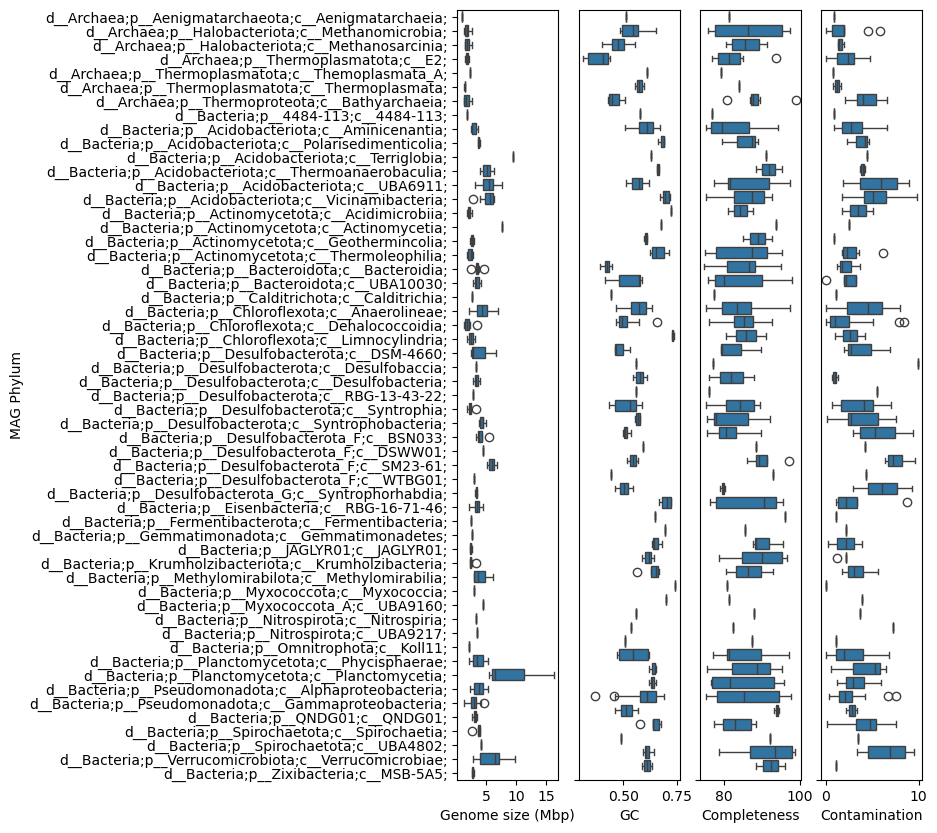

In [28]:
# Plot MAG statistics broken down by class
fig, ax = plt.subplots(1,4,figsize=(6,10))
sns.boxplot(ad.var.sort_values('class_plus'), y='class_plus', x='Genome size (Mbp)', ax=ax[0])
sns.boxplot(ad.var.sort_values('class_plus'), y='class_plus', x='GC', ax=ax[1])
sns.boxplot(ad.var.sort_values('class_plus'), y='class_plus', x='Completeness', ax=ax[2])
sns.boxplot(ad.var.sort_values('class_plus'), y='class_plus', x='Contamination', ax=ax[3])


ax[1].set_yticks('')
ax[2].set_yticks('')
ax[3].set_yticks('')

ax[0].set_ylabel('MAG Class')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

plt.savefig('figures/MAG_stats_by_class.png', dpi=450, bbox_inches='tight')
plt.show()

In [29]:
# Mean genome size per class
ad.var.groupby('class_plus')['Genome size (Mbp)'].mean()

class_plus
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;        0.952931
d__Archaea;p__Halobacteriota;c__Methanomicrobia;            1.825902
d__Archaea;p__Halobacteriota;c__Methanosarcinia;            1.874783
d__Archaea;p__Thermoplasmatota;c__E2;                       1.792430
d__Archaea;p__Thermoplasmatota;c__Themoplasmata_A;          2.353465
d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;           1.462143
d__Archaea;p__Thermoproteota;c__Bathyarchaeia;              1.792513
d__Bacteria;p__4484-113;c__4484-113;                        1.797220
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;            2.907257
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;     3.769793
d__Bacteria;p__Acidobacteriota;c__Terriglobia;              9.454902
d__Bacteria;p__Acidobacteriota;c__Thermoanaerobaculia;      5.079618
d__Bacteria;p__Acidobacteriota;c__UBA6911;                  5.171257
d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;         5.282054
d__Bacteria;p__Actinomy

In [30]:
# Standard deviation of genome size by class
ad.var.groupby('class_plus')['Genome size (Mbp)'].std()

class_plus
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;             NaN
d__Archaea;p__Halobacteriota;c__Methanomicrobia;            0.387108
d__Archaea;p__Halobacteriota;c__Methanosarcinia;            0.540522
d__Archaea;p__Thermoplasmatota;c__E2;                       0.246390
d__Archaea;p__Thermoplasmatota;c__Themoplasmata_A;               NaN
d__Archaea;p__Thermoplasmatota;c__Thermoplasmata;           0.105423
d__Archaea;p__Thermoproteota;c__Bathyarchaeia;              0.546989
d__Bacteria;p__4484-113;c__4484-113;                             NaN
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;            0.421333
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;     0.136099
d__Bacteria;p__Acidobacteriota;c__Terriglobia;                   NaN
d__Bacteria;p__Acidobacteriota;c__Thermoanaerobaculia;      1.634849
d__Bacteria;p__Acidobacteriota;c__UBA6911;                  1.354259
d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;         1.142155
d__Bacteria;p__Actinomy

## MAG functional analysis using DRAM module annotations

In [31]:
# Load in DRAM module data from the metabolism summary excel sheets
sheet_names = ['Energy','carbon utilization', 'MISC', 'Transporters', 'Organic Nitrogen','carbon utilization (Woodcroft)']

for i in range(4):
    for sheet in sheet_names:
        if sheet == 'Energy':
            df = pd.read_excel('data/MAGs/MAG_DRAM_metabolism_summary_{}.xlsx'.format(i+1), sheet_name=sheet, index_col=[0,1,2,3,4])
        else:
            df = pd.concat([df, pd.read_excel('data/MAGs/MAG_DRAM_metabolism_summary_{}.xlsx'.format(i+1), sheet_name=sheet, index_col=[0,1,2,3,4])])
    if i == 0:
        dram_df = df# to get rid of double counting .groupby(level=0).last()
    else:
        dram_df = dram_df.join(df, how='outer')#dram_df.join(df.iloc[:, 4:].groupby(level=0).last(), how='outer')

dram_df = dram_df.reset_index()
dram_df = dram_df.drop_duplicates()
dram_df = dram_df.set_index(['gene_id','gene_description','module','header','subheader'])
new_col_names = dict(zip(dram_df.columns, [i[0] for i in dram_df.columns.str.split('__', expand=True)]))
dram_df = dram_df.rename(new_col_names, axis=1)
dram_df = dram_df.reindex(sorted(dram_df.columns), axis=1)
dram_df

,,,,,3300055390_1033,3300055390_1034,3300055390_1041,3300055390_1045,3300055390_1047,3300055390_1048,3300055390_1051,3300055390_1052,3300055390_1054,3300055390_1056,...,3300067053_859,3300067053_861,3300067053_901,3300067053_944,3300067053_946,3300067053_951,3300067053_955,3300067053_962,3300067053_967,3300067053_980
gene_id,gene_description,module,header,subheader,,,,,,,,,,,,,,,,,,,,,
1.3.1.57,phloroglucinol reductase,"anaerobic gallate degradation, gallate => 3-hydroxybutanoyl-CoA",hydrocarbon degradation,pentose pathway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.97.1.2,pyrogallol transhydroxylase,"anaerobic gallate degradation, gallate => 3-hydroxybutanoyl-CoA",hydrocarbon degradation,pentose pathway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01A,"Catlytic type: Aspartate; residues with large hydrophobic sidechains on either side of the scissile bond, but several members have more restricted specificities that allow protein-processing functions (see additional Info); The amino acid sequences show signal peptides and propeptides except for bacterial homologues which also lack disulfide bridges and are probably cytoplasmic (Rawlings & Bateman, 2009). Many three-dimensional structures have been described. The catalytic site is located between the two lobes of the molecules, and a 'flap' structure containing a conserved Tyr residue controls specificity (James, 2004; Hong & Tang, 2004). Several of the peptidases are glycosylated (e.g. cathepsin D, A01.009) and a few are membrane-bound (memapsin-1 and memapsin-2, A01.041 and A01.004, respectively). Some family A1 peptidases from plants (e.g. phytepsin, A01.020) contain inserted saposin-like sequences, and the effects of these on enzymatic activity have been investigated (Payie et al., 2003). The secreted proteins in subfamily A usually have three conserved disulfide bridges, whereas in subfamily B there are six, and the unusual stability of nepenthesin (A01.040) to a wide pH range has been attributed to these disulfide bridges (Takahashi et al., 2005).",Endopeptidases (most of which are most active at acidic pH),Peptidase,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01B,"Catlytic type: Aspartate; residues with large hydrophobic sidechains on either side of the scissile bond, but several members have more restricted specificities that allow protein-processing functions (see additional Info); The amino acid sequences show signal peptides and propeptides except for bacterial homologues which also lack disulfide bridges and are probably cytoplasmic (Rawlings & Bateman, 2009). Many three-dimensional structures have been described. The catalytic site is located between the two lobes of the molecules, and a 'flap' structure containing a conserved Tyr residue controls specificity (James, 2004; Hong & Tang, 2004). Several of the peptidases are glycosylated (e.g. cathepsin D, A01.009) and a few are membrane-bound (memapsin-1 and memapsin-2, A01.041 and A01.004, respectively). Some family A1 peptidases from plants (e.g. phytepsin, A01.020) contain inserted saposin-like sequences, and the effects of these on enzymatic activity have been investigated (Payie et al., 2003). The secreted proteins in subfamily A usually have three conserved disulfide bridges, whereas in subfamily B there are six, and the unusual stability of nepenthesin (A01.040) to a wide pH range has been attributed to these disulfide bridges (Takahashi et al., 2005).",Endopeptidases (most of which are most active at acidic pH),Peptidase,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02A,Catlytic type: Aspartate; maximally active in the range pH 4-6,Endopeptidases,Peptidase,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [32]:
# Combine information into an AnnData object
bacteria_archaea = bacteria_archaea.reindex(sorted(bacteria_archaea.index), axis=0) # bin stats and taxonomy info
obs_df = dram_df.index.to_frame().reset_index(drop=True) # convert gene ortholog info in to dataframe for metadata
dram_ad = anndata.AnnData(X=(dram_df[bacteria_archaea.index]>0.).to_numpy(), obs=obs_df.reset_index(), var=bacteria_archaea) # creates AnnData with binary presence/absence data matrix
dram_ad

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3615 × 429
    obs: 'index', 'gene_id', 'gene_description', 'module', 'header', 'subheader'
    var: 'User Genome', 'Classification', 'FastANI Reference', 'FastANI Reference Radius', 'FastANI Taxonomy', 'FastANI ANI', 'FastANI Alignment Fraction', 'Closest Placement Reference', 'Closest Placement Taxonomy', 'Closest Placement ANI', 'Closest Placement Alignment Fraction', 'Classification Method', 'Note', 'Other Related References', 'MSA AA Percent', 'RED Value', 'Warnings', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'Bin Name', 'Marker Lineage', '# Genomes', '# Markers', '# Marker Sets', '0', '1', '2', '3', '4', '5+', 'Completeness', 'Contamination', 'Translation table', 'GC std', '# ambiguous bases', 'Genome size', 'Longest contig', 'N50 (scaffolds)', 'Mean scaffold length', '# contigs', '# scaffolds', '# predicted genes', 'Longest scaffold', 'GC', 'N50 (contigs)', 'Coding density', 'Mean contig length'

In [33]:
# Filter out low abundance MAGs
dram_ad = dram_ad[:, ad.var.index]

In [34]:
# create column with class information
dram_ad.var['class_plus'] = [i[0] for i in dram_ad.var['Classification'].str.split('o__')]
dram_ad.var

/tmp/ipykernel_5868/2300934102.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dram_ad.var['class_plus'] = [i[0] for i in dram_ad.var['Classification'].str.split('o__')]


,User Genome,Classification,FastANI Reference,FastANI Reference Radius,FastANI Taxonomy,FastANI ANI,FastANI Alignment Fraction,Closest Placement Reference,Closest Placement Taxonomy,Closest Placement ANI,...,Mean scaffold length,# contigs,# scaffolds,# predicted genes,Longest scaffold,GC,N50 (contigs),Coding density,Mean contig length,class_plus
3300060478_1093,3300060478_1093__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Anaerolineae;o...,-,-,-,-,-,-,-,-,...,15651.681223,229,229,3496,105628,0.529227,23684,0.915291,15651.681223,d__Bacteria;p__Chloroflexota;c__Anaerolineae;
3300060607_1232,3300060607_1232__dereplicated_genomes,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,-,-,-,-,-,GCA_009377445.1,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,83.4,...,7317.859813,535,535,4015,31766,0.652185,8523,0.887726,7317.856075,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
3300055390_922,3300055390_922__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Limnocylindria...,-,-,-,-,-,GCA_021802585.1,d__Bacteria;p__Chloroflexota;c__Limnocylindria...,81.47,...,11397.003690,271,271,3018,68526,0.727749,14873,0.899106,11397.003690,d__Bacteria;p__Chloroflexota;c__Limnocylindria;
3300055390_1093,3300055390_1093__dereplicated_genomes,d__Bacteria;p__Desulfobacterota;c__Syntrophia;...,-,-,-,-,-,GCA_021817825.1,d__Bacteria;p__Desulfobacterota;c__Syntrophia;...,79.11,...,10708.261438,306,306,3091,47058,0.585283,13525,0.892848,10708.261438,d__Bacteria;p__Desulfobacterota;c__Syntrophia;
3300067053_173,3300067053_173__dereplicated_genomes,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,-,-,-,-,-,GCA_019075925.1,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,78.97,...,7127.654036,607,607,4514,33701,0.629092,7778,0.862941,7127.654036,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300067053_692,3300067053_692__dereplicated_genomes,d__Archaea;p__Halobacteriota;c__Methanosarcini...,-,-,-,-,-,GCA_013178225.1,d__Archaea;p__Halobacteriota;c__Methanosarcini...,77.35,...,9503.060241,166,166,1660,42649,0.553437,11850,0.839442,9503.060241,d__Archaea;p__Halobacteriota;c__Methanosarcinia;
3300067053_1609,3300067053_1609__dereplicated_genomes,d__Archaea;p__Thermoplasmatota;c__E2;o__DHVEG-...,-,-,-,-,-,-,-,-,...,51074.697674,43,43,2155,169820,0.427374,72391,0.898434,51074.697674,d__Archaea;p__Thermoplasmatota;c__E2;
3300067053_594,3300067053_594__dereplicated_genomes,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,-,-,-,-,-,-,-,-,...,7592.550000,220,220,1737,39940,0.511195,8932,0.857768,7592.550000,d__Bacteria;p__Chloroflexota;c__Dehalococcoidia;
3300055390_915,3300055390_915__dereplicated_genomes,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,-,-,-,-,-,GCA_017860375.1,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,78.11,...,21710.018692,214,214,3687,161995,0.425369,33216,0.894682,21710.018692,d__Bacteria;p__Bacteroidota;c__Bacteroidia;


In [35]:
# Summarize module ko count for each module in each class
mag_class_kos = {}
for mag_class in set(dram_ad.var['class_plus']):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['class_plus']==mag_class].X, axis=0)/len(dram_ad.obs[dram_ad.obs.module==mod].index))
    mag_class_kos[mag_class] = mod_dict

In [36]:
# Turn mag class module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)

In [37]:
# export module summary as a csv
mag_class_ko_df.to_csv('output/mag_class_dram_df_FILTERED.csv')

In [38]:
# choose modules to plot
modules = ['Cytochrome c oxidase, cbb3-type', 'Cytochrome bd ubiquinol oxidase', 'F-type ATPase, prokaryotes and chloroplasts',
           'V/A-type ATPase, prokaryotes', 'RNF complex', 'NADH:quinone oxidoreductase, prokaryotes',
           'Non-phosphorylative Entner-Doudoroff pathway, gluconate/galactonate => glycerate',
           'Citrate cycle (TCA cycle, Krebs cycle)', 'Pentose phosphate pathway (Pentose phosphate cycle)',
           'Glycoside Hydrolases', 'Reductive acetyl-CoA pathway (Wood-Ljungdahl pathway)',
           'Dissimilatory sulfate reduction, sulfate => H2S', 'Dissimilatory nitrate reduction, nitrate => ammonia',
           'Denitrification, nitrate => nitrogen', 'Thiosulfate oxidation by SOX complex, thiosulfate => sulfate',
           'Polysaccharide Lyases','hydrogenase', 'Methanogenesis, acetate => methane', 'Methanogenesis, CO2 => methane', 'Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate',
          'Cobalamin biosynthesis, precorrin2 => cobinamide','Cobalamin biosynthesis, cobinamide => cobalamin',
       'Branched-chain amino acid transport system','Pentose phosphate pathway, archaea, fructose 6P => ribose 5P',
        'D-Galacturonate degradation (bacteria), D-galacturonate => pyruvate + D-glyceraldehyde 3P','Hydroxypropionate-hydroxybutylate cycle',
          'Galactose degradation, Leloir pathway, galactose => alpha-D-glucose-1P','Tryptophan biosynthesis, chorismate => tryptophan','SCFA  and alcohol conversions',
          'Reductive pentose phosphate cycle (Calvin cycle)','Methanogenesis, methylamine/dimethylamine/trimethylamine => methane','Fructose and mannose metabolism']
# shortened names for some modules for plot labels
module_labels = ['Cytochrome c oxidase, cbb3-type', 'Cytochrome bd ubiquinol oxidase', 'F-type ATPase',
           'V/A-type ATPase', 'RNF complex', 'NADH:quinone oxidoreductase',
           'Non-phosphorylative Entner-Doudoroff pathway',
           'Citrate cycle (TCA cycle, Krebs cycle)', 'Pentose phosphate pathway',
           'Glycoside Hydrolases', 'Reductive acetyl-CoA pathway (Wood-Ljungdahl)',
           'Dissimilatory sulfate reduction, sulfate => H2S', 'Dissimilatory nitrate reduction, nitrate => ammonia',
           'Denitrification, nitrate => nitrogen', 'Thiosulfate oxidation by SOX complex',
           'Polysaccharide Lyases','Hydrogenases', 'Methanogenesis, acetate => methane', 'Methanogenesis, CO2 => methane', 'Glycolysis (Embden-Meyerhof pathway)',
                'Cobalamin biosynthesis, precorrin2 => cobinamide','Cobalamin biosynthesis, cobinamide => cobalamin',
       'Branched-chain amino acid transport system','Pentose phosphate pathway (archaea)',
        'D-Galacturonate degradation (bacteria)','Hydroxypropionate-hydroxybutylate cycle',
          'Galactose degradation, Leloir pathway','Tryptophan biosynthesis, chorismate => tryptophan','SCFA  and alcohol conversions',
          'Reductive pentose phosphate cycle (Calvin cycle)','Methanogenesis, methylamines => methane','Fructose and mannose metabolism']
label_dict = dict(zip(modules, module_labels))

In [39]:
# choose modules to plot
modules = ['Fructose and mannose metabolism','Galactose metabolism','Pentose and glucuronate interconversions','Starch and sucrose metabolism',
          'Branched-chain amino acid transport system','Endopeptidases','Metalloendopeptidases','Metallo-endopeptidases','Aminopeptidases']

label_dict = dict(zip(modules, modules))

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


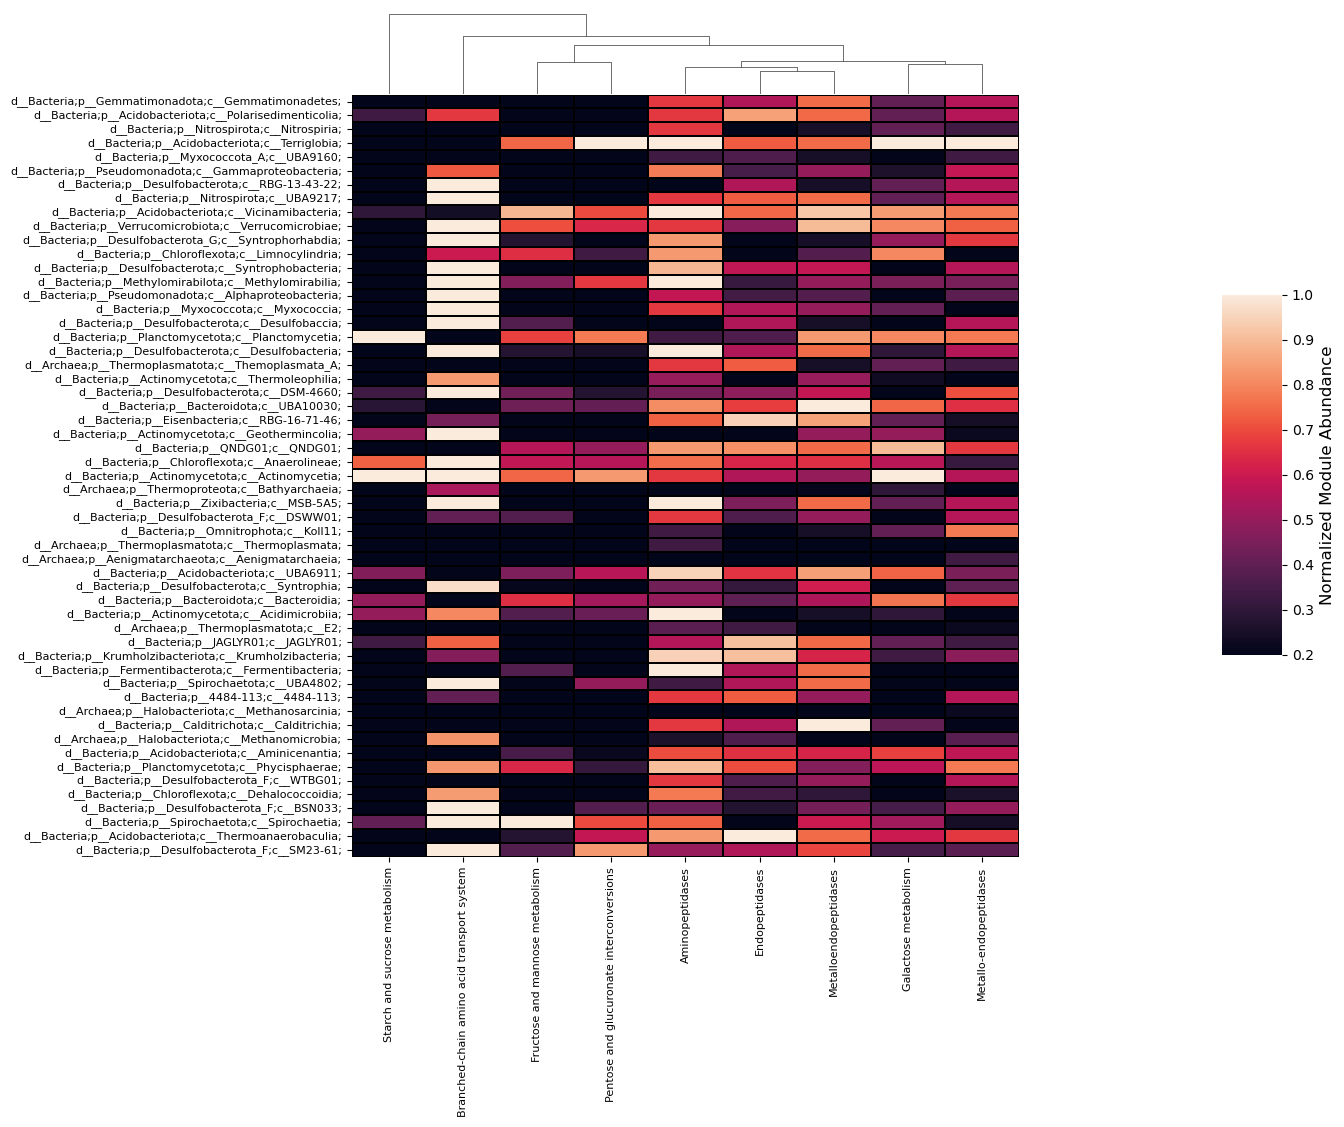

In [40]:
# Plot MAG class vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules].loc[mag_class_abun_df.index], figsize=(12,12), metric='braycurtis', square=True,
                    standard_scale=1, vmin=0.2, vmax=1, row_cluster=False, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.8, 0.45, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_abun_df.index)

ax.ax_heatmap.tick_params(labelsize=8)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

#plt.savefig('figures/mag_class_dram_module_FILTERED.svg', dpi=400, bbox_inches='tight')
plt.show()

In [41]:
# Version with fewer modules, organized


In [42]:
modules = ['Methanogenesis, CO2 => methane', 'Methanogenesis, acetate => methane', 'Methanogenesis, methylamine/dimethylamine/trimethylamine => methane','Methanogenesis, methanol => methane',
           'Dissimilatory sulfate reduction, sulfate => H2S','Thiosulfate oxidation by SOX complex, thiosulfate => sulfate','Denitrification, nitrate => nitrogen',
           'Dissimilatory nitrate reduction, nitrate => ammonia', 'hydrogenase',
           'V/A-type ATPase, prokaryotes', 'F-type ATPase, prokaryotes and chloroplasts','Cytochrome bc1 complex respiratory unit','Cytochrome c oxidase, prokaryotes',
            'Cytochrome c oxidase, cbb3-type','Cytochrome bd ubiquinol oxidase',
           'NADH:quinone oxidoreductase, prokaryotes','RNF complex',
           'Pyruvate oxidation, pyruvate => acetyl-CoA',
            'Reductive acetyl-CoA pathway (Wood-Ljungdahl pathway)','Acetyl-CoA pathway, CO2 => acetyl-CoA',
           'Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate',
          'Pentose phosphate pathway (Pentose phosphate cycle)','Pentose phosphate pathway, archaea, fructose 6P => ribose 5P',
        'D-galactonate degradation, De Ley-Doudoroff pathway, D-galactonate => glycerate-3P',
          'Galactose degradation, Leloir pathway, galactose => alpha-D-glucose-1P','Glyoxylate cycle',
          'Reductive pentose phosphate cycle (Calvin cycle)','Reductive citrate cycle (Arnon-Buchanan cycle)','SCFA  and alcohol conversions','Glycoside Hydrolases','Polysaccharide Lyases',
           'Benzoyl-CoA degradation, benzoyl-CoA => 3-hydroxypimeloyl-CoA','Branched-chain amino acid transport system',
          'Cobalamin biosynthesis, precorrin2 => cobinamide','Cobalamin biosynthesis, cobinamide => cobalamin',]
# shortened names for some modules for plot labels
module_labels = ['CO2 => methane', 'acetate => methane', 'methylamines => methane','methanol => methane',
           'Dissimilatory sulfate reduction','Thiosulfate oxidation by SOX','Denitrification',
           'DNRA', 'Hydrogenases',
           'V/A-type ATPase', 'F-type ATPase', 'Cytochrome bc1','Cytochrome c oxidase',
            'Cytochrome c oxidase, cbb3-type', 'Cytochrome bd ubiquinol oxidase',
           'NADH:quinone oxidoreductase','RNF complex',
           'Pyruvate oxidation',
            'Wood-Ljungdahl pathway','Acetyl-CoA pathway',
           'Glycolysis (EM pathway)',
          'Pentose phosphate pathway','Pentose phosphate pathway (archaea)',
        'D-Galacturonate degradation',
          'Galactose degradation','Glyoxylate cycle',
          'Reductive pentose phosphate cycle','Reductive citrate cycle','SCFA  and alcohol conversions', 'Glycoside Hydrolases','Polysaccharide Lyases',
            'Benzoyl-CoA degradation','Branched-chain amino acid transporter',
          'B12 biosynthesis-I','B12 biosynthesis-II',
    ]
label_dict = dict(zip(modules, module_labels))

In [43]:
mag_class_ko_df[modules].loc[mag_class_abun_df.index]

,"Methanogenesis, CO2 => methane","Methanogenesis, acetate => methane","Methanogenesis, methylamine/dimethylamine/trimethylamine => methane","Methanogenesis, methanol => methane","Dissimilatory sulfate reduction, sulfate => H2S","Thiosulfate oxidation by SOX complex, thiosulfate => sulfate","Denitrification, nitrate => nitrogen","Dissimilatory nitrate reduction, nitrate => ammonia",hydrogenase,"V/A-type ATPase, prokaryotes",...,Glyoxylate cycle,Reductive pentose phosphate cycle (Calvin cycle),Reductive citrate cycle (Arnon-Buchanan cycle),SCFA and alcohol conversions,Glycoside Hydrolases,Polysaccharide Lyases,"Benzoyl-CoA degradation, benzoyl-CoA => 3-hydroxypimeloyl-CoA",Branched-chain amino acid transport system,"Cobalamin biosynthesis, precorrin2 => cobinamide","Cobalamin biosynthesis, cobinamide => cobalamin"
d__Bacteria;p__Gemmatimonadota;c__Gemmatimonadetes;,0.135135,0.032258,0.000000,0.000000,0.000000,0.300000,0.181818,0.111111,0.000000,0.111111,...,0.333333,0.277778,0.232558,0.000000,0.000000,0.000000,0.111111,0.200000,0.000000,0.111111
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;,0.054054,0.139785,0.101449,0.105263,0.000000,0.033333,0.090909,0.111111,0.008889,0.000000,...,0.296296,0.222222,0.286822,0.041667,0.006024,0.026316,0.259259,0.666667,0.000000,0.111111
d__Bacteria;p__Nitrospirota;c__Nitrospiria;,0.000000,0.032258,0.000000,0.000000,0.142857,0.100000,0.000000,0.111111,0.000000,0.000000,...,0.111111,0.277778,0.255814,0.000000,0.006024,0.000000,0.000000,0.200000,0.057143,0.666667
d__Bacteria;p__Acidobacteriota;c__Terriglobia;,0.162162,0.258065,0.217391,0.263158,0.285714,0.000000,0.090909,0.000000,0.106667,0.000000,...,0.333333,0.277778,0.395349,0.062500,0.030120,0.052632,0.000000,0.200000,0.000000,0.111111
d__Bacteria;p__Myxococcota_A;c__UBA9160;,0.027027,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.111111,0.222222,0.209302,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;,0.056404,0.098177,0.058601,0.070938,0.490683,0.465217,0.335968,0.371981,0.027826,0.188406,...,0.241546,0.405797,0.298281,0.029891,0.006810,0.004577,0.038647,0.721739,0.080745,0.241546
d__Bacteria;p__Desulfobacterota;c__RBG-13-43-22;,0.243243,0.322581,0.347826,0.421053,0.000000,0.000000,0.090909,0.111111,0.053333,0.000000,...,0.111111,0.222222,0.418605,0.000000,0.006024,0.000000,0.333333,1.000000,0.342857,0.444444
d__Bacteria;p__Nitrospirota;c__UBA9217;,0.027027,0.096774,0.000000,0.000000,0.285714,0.100000,0.454545,0.444444,0.013333,0.000000,...,0.111111,0.277778,0.302326,0.000000,0.006024,0.000000,0.000000,1.000000,0.057143,0.333333
d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;,0.075676,0.154839,0.152174,0.142105,0.157143,0.130000,0.127273,0.122222,0.062667,0.000000,...,0.277778,0.205556,0.286047,0.056250,0.024096,0.052632,0.000000,0.240000,0.017143,0.111111
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;,0.135135,0.206452,0.226087,0.263158,0.171429,0.020000,0.036364,0.088889,0.138667,0.111111,...,0.244444,0.255556,0.223256,0.025000,0.026506,0.131579,0.000000,1.000000,0.022857,0.111111


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


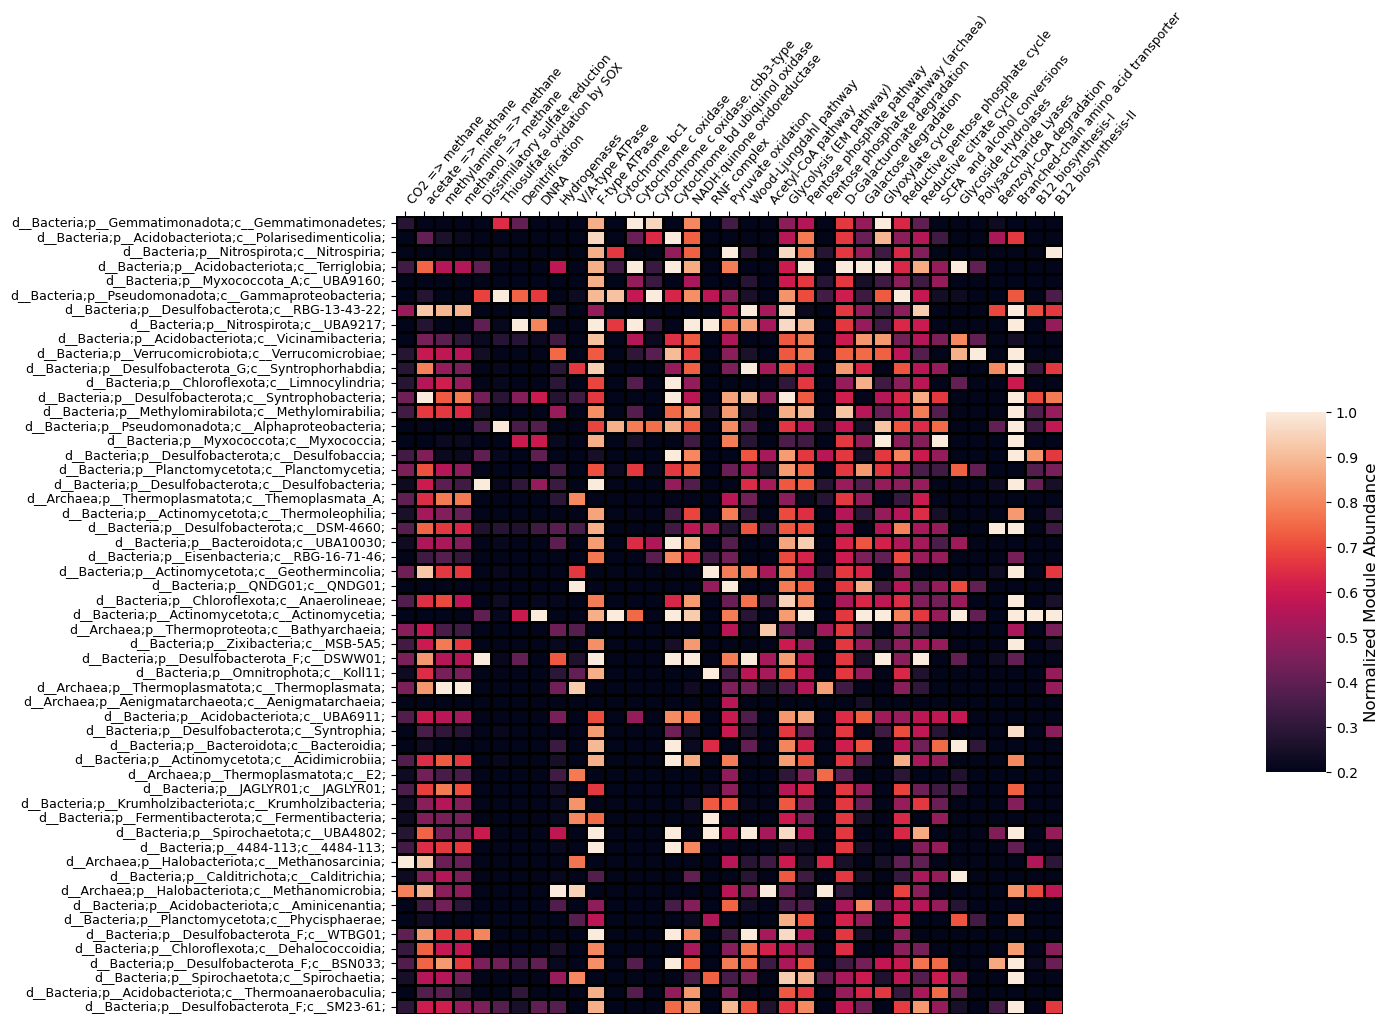

In [44]:
# Plot MAG class vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules].loc[mag_class_abun_df.index], figsize=(12,12), metric='euclidean', square=True,
                     standard_scale=1, vmin=0.2, vmax=1,col_cluster=False, row_cluster=False, linewidths=0.9, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.8, 0.45, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_abun_df.index)

ax.ax_heatmap.tick_params(labelsize=9)
ax.ax_heatmap.xaxis.tick_top()
ax.ax_heatmap.yaxis.tick_left()
for label in ax.ax_heatmap.get_xticklabels():
    label.set_rotation(50)  # Set rotation
    label.set_horizontalalignment('left')  # Align horizontally
ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_heatmap.svg', dpi=400, bbox_inches='tight')
plt.show()

### Look at just MAGs within Pseudomonadota

In [45]:
subset = dram_ad[:, dram_ad.var.phylum=='p__Pseudomonadota']
# Summarize module ko count for each module in each species
mag_class_kos = {}
for mag_class in set(subset.var.Classification):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['Classification']==mag_class].X, axis=0))
    mag_class_kos[mag_class] = mod_dict
# Turn mag phylum module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)
mag_class_ko_df

,Serine peptidase inhibitors,"Malonate semialdehyde pathway, propanoyl-CoA => acetyl-CoA","Cobalamin biosynthesis, precorrin2 => cobinamide","PTS system, glucitol/sorbitol-specific II component","Phenylalanine biosynthesis, chorismate => phenylalanine",Sulfonate transport system,"Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",Endopeptidases involved in the processing of polyproteins encoded by retrotransposons,Viral processing endopeptidases,PfpI endopeptidase of {Pyrococcus furiosus},...,Serine endopeptidases of bacteria,"PTS system, N-acetylgalactosamine-specific II component",Glutamate/aspartate transport system,Uncharacterized ABC transport system,Serine endopeptidases,Polyprotein-processing peptidases of hepatitis viruses,Putative xylitol transport system,"Reductive pentose phosphate cycle, glyceraldehyde-3P => ribulose-5P",alpha-Glucoside transport system,Aspartate/glutamate/glutamine transport system
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhizobiales;f__Methyloligellaceae;g__Methyloceanibacter;s__,0.0,1.000000,10.0,0.0,0.5,0.000000,2.5,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.0,0.0,0.0
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__BOG-931;s__,0.0,2.000000,10.0,0.0,1.0,0.000000,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Bradyrhizobium;s__,0.0,2.000000,5.0,0.0,2.0,2.000000,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,1.0,0.0
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Pseudolabrys;s__,0.0,2.000000,3.0,0.0,1.0,3.000000,2.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,3.5,1.0,0.0,4.0,1.0,0.0
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Z2-YC6860;s__,0.0,2.000000,3.0,0.0,1.0,2.000000,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
d__Bacteria;p__Pseudomonadota;c__Alphaproteobacteria;o__UBA8366;f__UBA8366;g__WHUA01;s__,0.0,3.000000,2.0,0.0,1.0,3.000000,2.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Acidiferrobacterales;f__UBA6901;g__UBA6901;s__,0.0,0.333333,3.0,0.0,1.0,0.666667,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae_A;g__JADJWR01;s__,0.0,2.000000,0.0,0.0,1.0,2.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,1.0,0.0
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae_B;g__CADEEN01;s__,0.0,2.000000,2.0,0.0,2.0,1.000000,3.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0
d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Burkholderiales;f__Gallionellaceae;g__Gallionella;s__,0.0,0.000000,3.0,0.0,0.5,0.000000,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.5,0.0,0.0


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


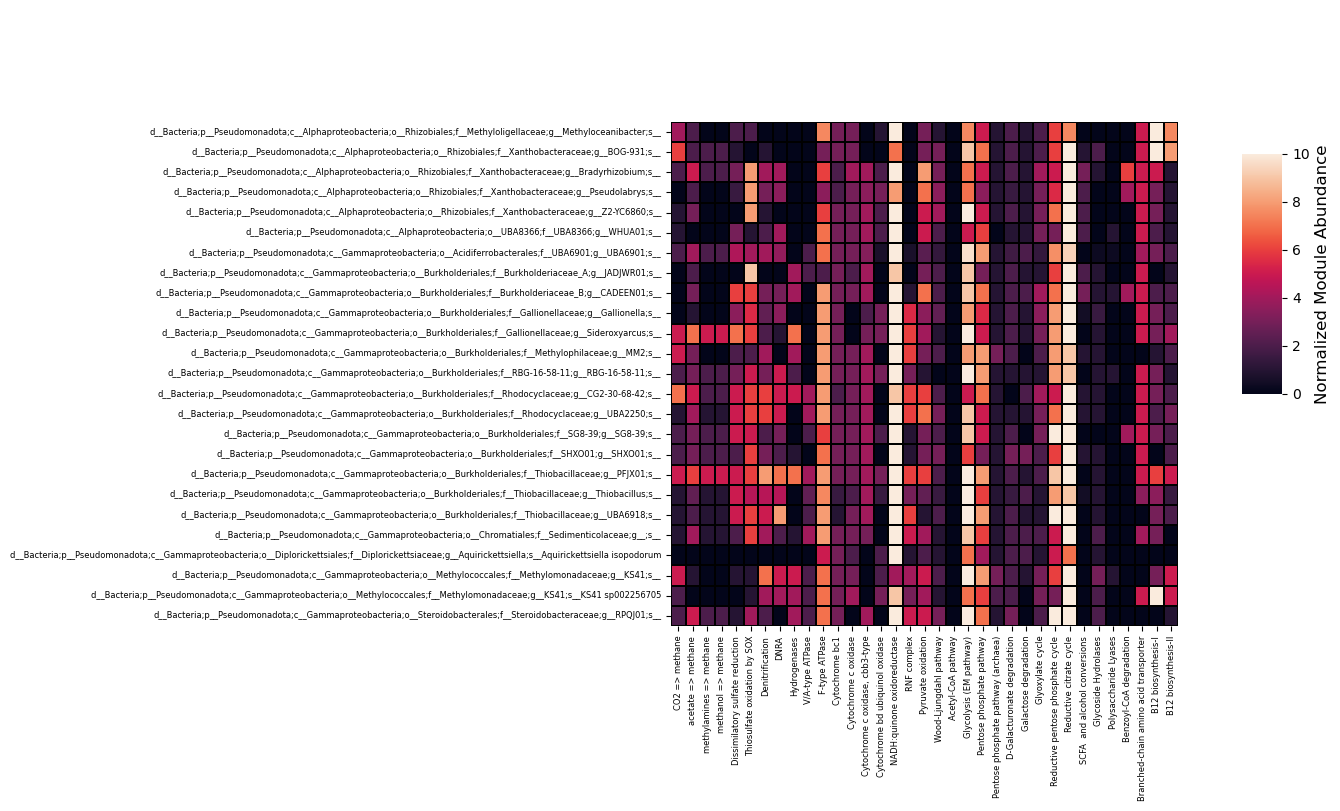

In [46]:
# Plot MAG species vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules], figsize=(8,8), metric='euclidean', square=True,
                    col_cluster=False, row_cluster=False,vmax=10, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.98, 0.4, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_ko_df.index)

ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_Pseudomonadota.svg', dpi=400, bbox_inches='tight')
plt.show()

### Repeat with Acidobacterota

In [47]:
subset = dram_ad[:, dram_ad.var.phylum=='p__Acidobacteriota']
# Summarize module ko count for each module in each species
mag_class_kos = {}
for mag_class in set(subset.var.Classification):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['Classification']==mag_class].X, axis=0))
    mag_class_kos[mag_class] = mod_dict
# Turn mag phylum module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)
mag_class_ko_df

,Serine peptidase inhibitors,"Malonate semialdehyde pathway, propanoyl-CoA => acetyl-CoA","Cobalamin biosynthesis, precorrin2 => cobinamide","PTS system, glucitol/sorbitol-specific II component","Phenylalanine biosynthesis, chorismate => phenylalanine",Sulfonate transport system,"Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",Endopeptidases involved in the processing of polyproteins encoded by retrotransposons,Viral processing endopeptidases,PfpI endopeptidase of {Pyrococcus furiosus},...,Serine endopeptidases of bacteria,"PTS system, N-acetylgalactosamine-specific II component",Glutamate/aspartate transport system,Uncharacterized ABC transport system,Serine endopeptidases,Polyprotein-processing peptidases of hepatitis viruses,Putative xylitol transport system,"Reductive pentose phosphate cycle, glyceraldehyde-3P => ribulose-5P",alpha-Glucoside transport system,Aspartate/glutamate/glutamine transport system
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;o__Aminicenantales;f__;g__;s__,0.0,2.000000,0.000000,0.0,0.000000,0.0,2.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,4.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;o__Aminicenantales;f__RBG-16-66-30;g__RBG-16-66-30;s__,0.0,0.800000,0.000000,0.0,0.000000,0.0,1.2,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,3.600000,0.6,0.0,3.400000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;o__Aminicenantales;f__UBA8522;g__;s__,0.0,1.000000,0.000000,0.0,0.000000,0.0,2.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,1.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;o__Aminicenantales;f__UBA8522;g__UBA8522;s__,0.0,2.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,3.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Aminicenantia;o__UBA2199;f__UBA2199;g__UBA2199;s__,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,4.000000,0.5,0.0,2.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;o__Polarisedimenticolales;f__Polarisedimenticolaceae;g__;s__,0.0,1.000000,0.000000,0.0,0.000000,0.0,2.0,0.0,0.0,0.500000,...,0.5,0.0,0.0,0.0,5.000000,0.0,0.0,2.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Polarisedimenticolia;o__Polarisedimenticolales;f__Polarisedimenticolaceae;g__JAIQFR01;s__,0.0,1.000000,0.000000,0.0,0.000000,3.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,6.000000,0.0,0.0,2.000000,1.0,0.0
d__Bacteria;p__Acidobacteriota;c__Terriglobia;o__Bryobacterales;f__Bryobacteraceae;g__Solibacter;s__,0.0,0.000000,0.000000,0.0,1.000000,0.0,3.0,0.0,0.0,1.000000,...,1.0,0.0,0.0,0.0,6.000000,0.0,2.0,3.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Thermoanaerobaculia;o__Thermoanaerobaculales;f__Thermoanaerobaculaceae;g__JAAYVZ01;s__,0.0,1.000000,0.000000,0.0,0.000000,2.0,2.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,4.000000,0.0,0.0,2.000000,0.0,0.0
d__Bacteria;p__Acidobacteriota;c__Thermoanaerobaculia;o__Thermoanaerobaculales;f__Thermoanaerobaculaceae;g__RBG-13-68-16;s__,0.0,1.000000,0.000000,0.0,0.000000,3.0,2.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,2.000000,1.0,0.0


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


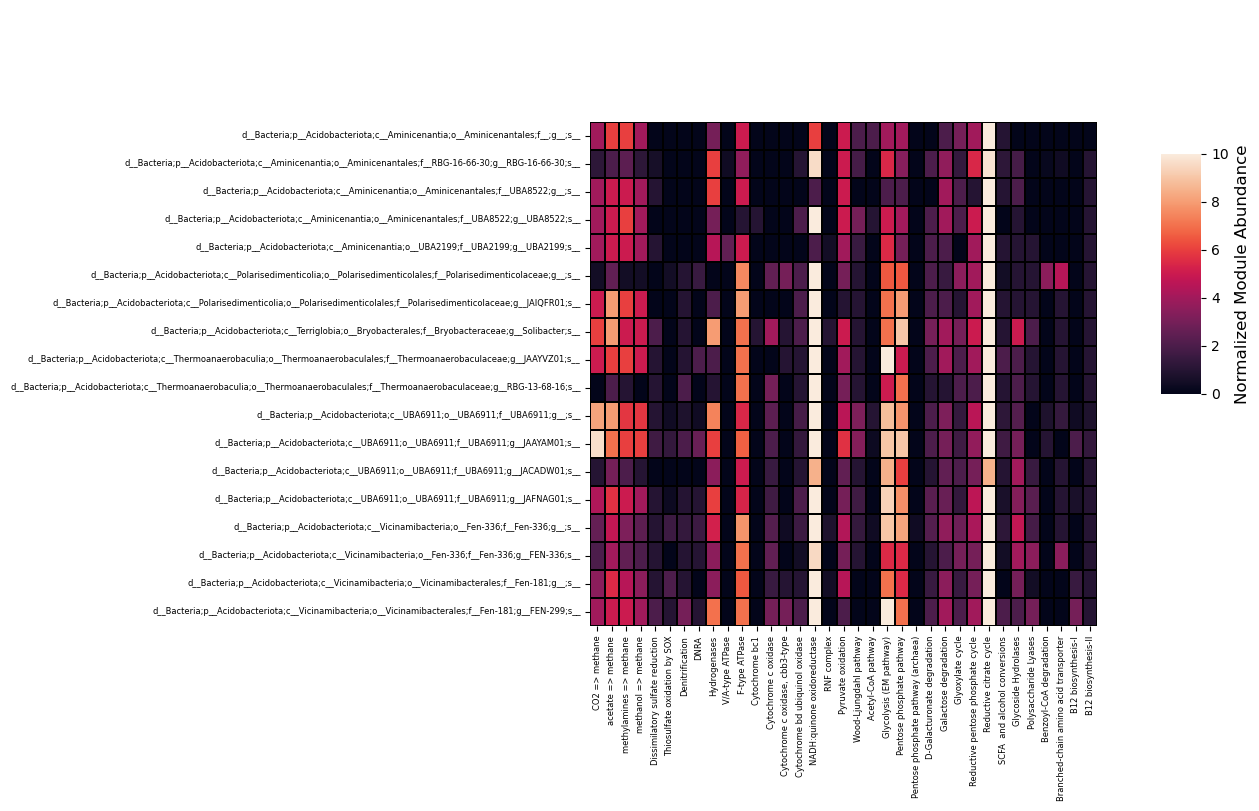

In [48]:
# Plot MAG species vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules], figsize=(8,8), metric='euclidean', square=True,
                    vmax=10, col_cluster=False, row_cluster=False, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.98, 0.4, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_ko_df.index)

ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_Acidobacteriota.svg', dpi=400, bbox_inches='tight')
plt.show()

### Chloroflexota

In [49]:
subset = dram_ad[:, dram_ad.var.phylum=='p__Chloroflexota']
# Summarize module ko count for each module in each species
mag_class_kos = {}
for mag_class in set(subset.var.Classification):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['Classification']==mag_class].X, axis=0))
    mag_class_kos[mag_class] = mod_dict
# Turn mag phylum module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)
mag_class_ko_df

,Serine peptidase inhibitors,"Malonate semialdehyde pathway, propanoyl-CoA => acetyl-CoA","Cobalamin biosynthesis, precorrin2 => cobinamide","PTS system, glucitol/sorbitol-specific II component","Phenylalanine biosynthesis, chorismate => phenylalanine",Sulfonate transport system,"Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",Endopeptidases involved in the processing of polyproteins encoded by retrotransposons,Viral processing endopeptidases,PfpI endopeptidase of {Pyrococcus furiosus},...,Serine endopeptidases of bacteria,"PTS system, N-acetylgalactosamine-specific II component",Glutamate/aspartate transport system,Uncharacterized ABC transport system,Serine endopeptidases,Polyprotein-processing peptidases of hepatitis viruses,Putative xylitol transport system,"Reductive pentose phosphate cycle, glyceraldehyde-3P => ribulose-5P",alpha-Glucoside transport system,Aspartate/glutamate/glutamine transport system
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Aggregatilineales;f__UBA3940;g__JAFGMS01;s__,0.0,0.000000,0.0,0.0,2.0,0.0,3.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,3.0,1.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__JAFGXF01;s__,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,4.0,1.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__EnvOPS12;g__;s__,0.0,2.000000,0.0,0.0,1.0,0.0,2.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,4.000000,0.0,0.0,4.0,1.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__EnvOPS12;g__UBA877;s__,0.0,0.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,4.000000,0.0,0.0,3.0,1.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__RBG-16-64-43;g__JAFGKK01;s__,0.0,0.000000,0.0,0.0,0.0,3.0,3.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,1.0,1.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__UBA4823;g__;s__,0.0,0.000000,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,4.000000,0.0,0.0,2.0,4.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__UBA4823;g__CTSoil-045;s__,0.0,1.500000,0.0,0.0,1.0,0.0,2.000000,0.0,0.0,0.500000,...,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,4.5,4.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__UBA4823;g__FEB-25;s__,0.0,2.000000,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.500000,...,0.0,0.0,0.0,0.0,3.500000,0.0,0.0,3.0,2.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__UBA4823;g__RBG-16-57-11;s__,0.0,1.000000,0.0,0.0,2.0,0.0,3.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,6.000000,0.0,0.0,4.0,2.0,0.0
d__Bacteria;p__Chloroflexota;c__Anaerolineae;o__Anaerolineales;f__UBA6663;g__;s__,0.0,1.000000,0.0,0.0,2.0,3.0,0.000000,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,5.000000,0.0,0.0,4.0,1.0,0.0


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


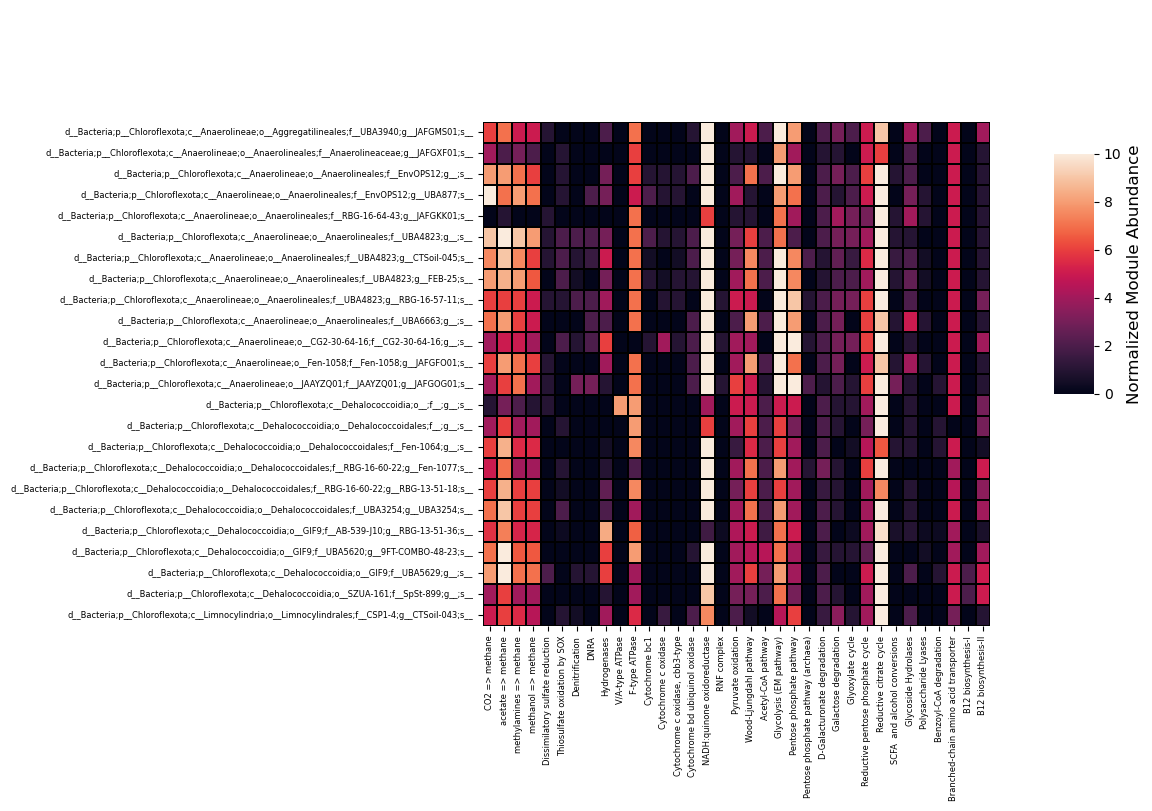

In [50]:
# Plot MAG species vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules], figsize=(8,8), metric='euclidean', square=True,
                    vmax=10, col_cluster=False, row_cluster=False, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.98, 0.4, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_ko_df.index)

ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_Chloroflexota.svg', dpi=400, bbox_inches='tight')
plt.show()

### Desulfobacterota

In [51]:
subset = dram_ad[:, (dram_ad.var.phylum=='p__Desulfobacterota')|(dram_ad.var.phylum=='p__Desulfobacterota_F')]
# Summarize module ko count for each module in each species
mag_class_kos = {}
for mag_class in set(subset.var.Classification):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['Classification']==mag_class].X, axis=0))
    mag_class_kos[mag_class] = mod_dict
# Turn mag species module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)
mag_class_ko_df

,Serine peptidase inhibitors,"Malonate semialdehyde pathway, propanoyl-CoA => acetyl-CoA","Cobalamin biosynthesis, precorrin2 => cobinamide","PTS system, glucitol/sorbitol-specific II component","Phenylalanine biosynthesis, chorismate => phenylalanine",Sulfonate transport system,"Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",Endopeptidases involved in the processing of polyproteins encoded by retrotransposons,Viral processing endopeptidases,PfpI endopeptidase of {Pyrococcus furiosus},...,Serine endopeptidases of bacteria,"PTS system, N-acetylgalactosamine-specific II component",Glutamate/aspartate transport system,Uncharacterized ABC transport system,Serine endopeptidases,Polyprotein-processing peptidases of hepatitis viruses,Putative xylitol transport system,"Reductive pentose phosphate cycle, glyceraldehyde-3P => ribulose-5P",alpha-Glucoside transport system,Aspartate/glutamate/glutamine transport system
d__Bacteria;p__Desulfobacterota;c__DSM-4660;o__Desulfatiglandales;f__HGW-15;g__;s__,0.0,1.5,0.00,0.0,0.0,0.50,2.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.50,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__DSM-4660;o__Desulfatiglandales;f__HGW-15;g__JAFGIC01;s__,0.0,1.0,0.00,0.0,1.0,0.00,2.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Desulfobaccia;o__Desulfobaccales;f__Desulfobaccaceae;g__Desulfobacca;s__,0.0,1.0,14.00,0.0,1.0,0.00,2.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__C00003060;f__C00003060;g__JAFDGP01;s__,0.0,1.0,2.00,0.0,1.0,2.00,2.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__UBA2174_A;g__SpSt-501;s__,0.0,2.0,12.00,0.0,0.0,1.00,2.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,4.0,1.0,0.0,2.00,1.0,0.0
d__Bacteria;p__Desulfobacterota;c__RBG-13-43-22;o__RBG-13-43-22;f__RBG-13-43-22;g__;s__,0.0,1.0,12.00,0.0,1.0,0.00,2.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Fen-1087;g__Fen-1087;s__,0.0,1.0,0.00,0.0,1.0,0.00,1.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Smithellaceae;g__UBA4810;s__,0.0,0.5,1.00,0.0,1.0,0.00,2.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.50,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__UBA2185;g__UBA2185;s__,0.0,1.0,0.00,0.0,2.0,0.00,3.00,0.00,0.0,1.00,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.00,0.0,0.0
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__UBA4778;g__UBA4054;s__,0.0,1.5,6.00,0.0,1.0,0.00,2.50,0.00,0.0,0.50,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,3.00,0.0,0.0


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


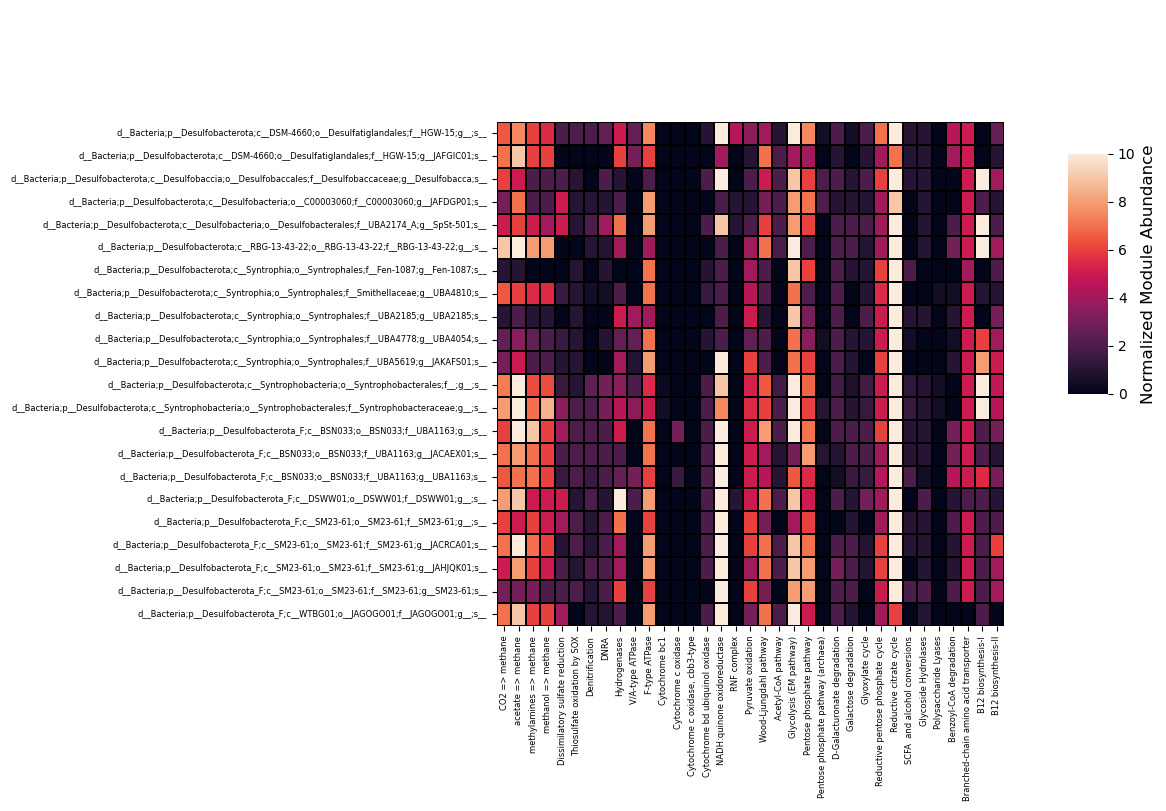

In [52]:
# Plot MAG species vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules], figsize=(8,8), metric='euclidean', square=True,
                    vmax=10, col_cluster=False, row_cluster=False, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.98, 0.4, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_ko_df.index)

ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_Desulfobacterota.svg', dpi=400, bbox_inches='tight')
plt.show()

### Archaea

In [53]:
subset = dram_ad[:, (dram_ad.var.domain=='d__Archaea')]
# Summarize module ko count for each module in each species
mag_class_kos = {}
for mag_class in set(subset.var.Classification):
    mod_dict = {}
    for mod in set(dram_ad.obs.module):
            mod_dict[mod] = np.mean(np.sum(dram_ad[dram_ad.obs.module == mod, dram_ad.var['Classification']==mag_class].X, axis=0))
    mag_class_kos[mag_class] = mod_dict
# Turn mag species module info into dataframe
mag_class_ko_df = pd.DataFrame(mag_class_kos).T.sort_index().astype(float)
mag_class_ko_df.sort_index(inplace=True)
mag_class_ko_df.fillna(0., inplace=True)
mag_class_ko_df

,Serine peptidase inhibitors,"Malonate semialdehyde pathway, propanoyl-CoA => acetyl-CoA","Cobalamin biosynthesis, precorrin2 => cobinamide","PTS system, glucitol/sorbitol-specific II component","Phenylalanine biosynthesis, chorismate => phenylalanine",Sulfonate transport system,"Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",Endopeptidases involved in the processing of polyproteins encoded by retrotransposons,Viral processing endopeptidases,PfpI endopeptidase of {Pyrococcus furiosus},...,Serine endopeptidases of bacteria,"PTS system, N-acetylgalactosamine-specific II component",Glutamate/aspartate transport system,Uncharacterized ABC transport system,Serine endopeptidases,Polyprotein-processing peptidases of hepatitis viruses,Putative xylitol transport system,"Reductive pentose phosphate cycle, glyceraldehyde-3P => ribulose-5P",alpha-Glucoside transport system,Aspartate/glutamate/glutamine transport system
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__QMZP01;f__QMZP01;g__;s__,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanomicrobia;o__Methanomicrobiales;f__JACTUA01;g__JACTUA01;s__,0.0,0.0,11.5,0.0,0.0,1.0,0.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,1.500000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanoregulaceae;g__MVRE01;s__,0.0,0.0,13.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.500000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanoregulaceae;g__Methanoregula;s__,0.0,0.0,11.6,0.0,0.0,1.0,0.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,2.200000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanosarcinia;o__Methanosarcinales;f__Methanoperedenaceae;g__Methanoperedens;s__,0.0,0.0,12.0,0.0,1.0,0.0,3.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,3.000000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanosarcinia;o__Methanotrichales;f__Methanotrichaceae;g__Fen-7;s__,0.0,0.0,11.0,0.0,1.0,2.0,1.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanosarcinia;o__Methanotrichales;f__Methanotrichaceae;g__JABLXE01;s__,0.0,0.0,11.0,0.0,0.0,1.0,1.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,1.000000,0.0,0.0
d__Archaea;p__Halobacteriota;c__Methanosarcinia;o__Methanotrichales;f__Methanotrichaceae;g__Methanothrix;s__,0.0,0.0,3.0,0.0,0.0,2.0,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0
d__Archaea;p__Thermoplasmatota;c__E2;o__DHVEG-1;f__DHVEG-1;g__;s__,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.00,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,2.000000,0.0,0.0
d__Archaea;p__Thermoplasmatota;c__E2;o__DHVEG-1;f__DHVEG-1;g__SG8-52-3;s__,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,2.000000,0.0,0.0


/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


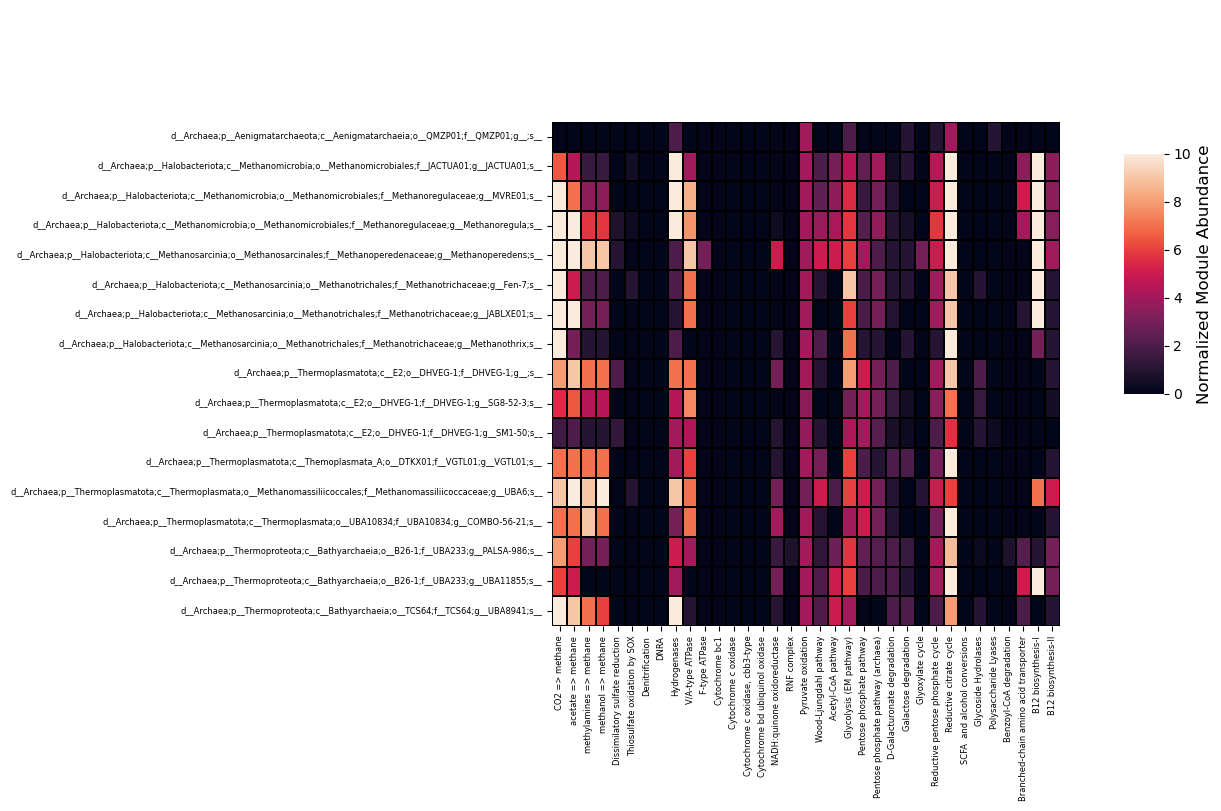

In [54]:
# Plot MAG species vs normalized module abundance
ax = sns.clustermap(mag_class_ko_df[modules], figsize=(8,8), metric='euclidean', square=True,
                    vmax=10, col_cluster=False, row_cluster=False, linewidths=0.1, dendrogram_ratio=0.1, linecolor='black',
                   cbar_pos=(0.98, 0.4, 0.05, 0.3), xticklabels=[label_dict[i] for i in modules], yticklabels=mag_class_ko_df.index)

ax.ax_heatmap.tick_params(labelsize=6)
ax.ax_heatmap.xaxis.tick_bottom()
ax.ax_heatmap.yaxis.tick_left()

ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/mag_class_dram_module_FILTERED_Archaea.svg', dpi=400, bbox_inches='tight')
plt.show()

### Look up specific functions in MAGs

In [55]:
def lookup_module_class(data, module, class_name):
    """Subsets data for modules and classes and outputs a filtered dataframe"""
    subset = data[data.obs.module==module, data.var['class'] == class_name]
    module_df = subset.obs
    module_dict = {}
    for i,j in enumerate(subset.var['Classification']):
        module_dict[j.split('o__')[1]+'-'+str(i)] = subset.X.T[i]
    return(pd.concat([module_df.reset_index(),pd.DataFrame(module_dict).sort_index(axis=1)], axis=1))

In [57]:
# Export details from select modules and classes
mods = ['Denitrification, nitrate => nitrogen','Dissimilatory nitrate reduction, nitrate => ammonia',
        'Thiosulfate oxidation by SOX complex, thiosulfate => sulfate','Dissimilatory sulfate reduction, sulfate => H2S',
        'SCFA  and alcohol conversions']
classes = ['c__Gammaproteobacteria','c__Alphaproteobacteria','c__UBA9217','c__Vicinamibacteria','c__Syntrophobacteria','c__BSN033']
for mod in mods:
    for c in classes:
        lookup_module_class(dram_ad, mod, c).T.to_csv('output/mag_pathway_details/'+mod+'-'+c+'.csv')

In [59]:
# Export details from select modules
mods = ['Methanogenesis, CO2 => methane', 'Methanogenesis, acetate => methane', 'Methanogenesis, methylamine/dimethylamine/trimethylamine => methane','Methanogenesis, methanol => methane',
           'Dissimilatory sulfate reduction, sulfate => H2S','Thiosulfate oxidation by SOX complex, thiosulfate => sulfate','Denitrification, nitrate => nitrogen',
           'Dissimilatory nitrate reduction, nitrate => ammonia', 'hydrogenase',
           'V/A-type ATPase, prokaryotes', 'F-type ATPase, prokaryotes and chloroplasts','Cytochrome d ubiquinol oxidase','Cytochrome c oxidase, prokaryotes',
            'Cytochrome c oxidase, cbb3-type','Cytochrome bd ubiquinol oxidase',
           'NADH:quinone oxidoreductase, prokaryotes','RNF complex',
           'Pyruvate oxidation, pyruvate => acetyl-CoA',
            'Reductive acetyl-CoA pathway (Wood-Ljungdahl pathway)','Acetyl-CoA pathway, CO2 => acetyl-CoA',
           'Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate',
          'Pentose phosphate pathway (Pentose phosphate cycle)','Pentose phosphate pathway, archaea, fructose 6P => ribose 5P',
        'D-galactonate degradation, De Ley-Doudoroff pathway, D-galactonate => glycerate-3P',
          'Galactose degradation, Leloir pathway, galactose => alpha-D-glucose-1P','Glyoxylate cycle',
          'Reductive pentose phosphate cycle (Calvin cycle)','Reductive citrate cycle (Arnon-Buchanan cycle)','SCFA  and alcohol conversions','Glycoside Hydrolases','Polysaccharide Lyases',
           'Benzoyl-CoA degradation, benzoyl-CoA => 3-hydroxypimeloyl-CoA','Branched-chain amino acid transport system',
          'Cobalamin biosynthesis, precorrin2 => cobinamide','Cobalamin biosynthesis, cobinamide => cobalamin','Methane oxidation, methanotroph, methane => formaldehyde']
for mod in mods:
    subset = dram_ad[dram_ad.obs.module==mod,:]
    pd.DataFrame(subset.X, index=pd.MultiIndex.from_frame(subset.obs.iloc[:,1:3]), columns=subset.var.Classification).T.sort_index().to_csv('output/mag_pathway_details/'+mod.replace('/','-')+'.csv')

In [60]:
for i in range(4):
    if i == 0:
        df = pd.read_csv('data/MAG_DRAM_annotations_{}.tsv'.format(i+1), sep='\t')
    else:
        df = pd.concat([df, pd.read_csv('data/MAG_DRAM_annotations_{}.tsv'.format(i+1), sep='\t')])
df['genome'] = df['fasta'].str.split('__', expand=True)[0]
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/MAG_DRAM_annotations_1.tsv'

In [ ]:
genome_dict = {}
for genome_id in list(set(df.genome)):
    tmp = pd.DataFrame(df[df.genome==genome_id].groupby('ko_id')['kegg_hit'].value_counts())
    tmp.rename({'count':genome_id}, axis=1, inplace=True)
    genome_dict[genome_id] = tmp
genome_dict

In [ ]:
gene_abundance = pd.concat(genome_dict.values(), axis=1, join='outer')
gene_abundance.fillna(0, inplace=True)
gene_abundance = gene_abundance.reindex(sorted(gene_abundance.columns), axis=1)
gene_abundance.head()

In [ ]:
bacteria_archaea = bacteria_archaea.reindex(sorted(bacteria_archaea.index), axis=0)

In [ ]:
obs_df = pd.DataFrame([gene_abundance.index.get_level_values('ko_id'), gene_abundance.index.get_level_values('kegg_hit')]).T
obs_df.rename({0:'ko_id', 1:'ko_name'}, axis=1, inplace=True)
obs_df.set_index('ko_id', inplace=True)
dram_ad = anndata.AnnData(X=(gene_abundance>0.).to_numpy(), obs=obs_df, var=bacteria_archaea)
dram_ad = dram_ad[np.max(dram_ad.X, axis=1)>0., :]
dram_ad

In [ ]:
dram_ad.var['class_plus'] = [i[0] for i in dram_ad.var['Classification'].str.split('o__')]
dram_ad.var

In [ ]:
# Filter out low abundance MAGs
dram_ad = dram_ad[:, ad.var.index]
dram_ad

In [ ]:
pathways = pd.read_excel('data/curated_pathways.xlsx')
pathways

In [ ]:
pathway_dict = {}
for pathway in pathways['Pathway name'].drop_duplicates():
    KOs = pathways[pathways['Pathway name']==pathway]['KO']
    subset_ad = dram_ad[[i for i in KOs if i in dram_ad.obs.index], :]
    pathway_dict[pathway] = np.sum(subset_ad.X, axis=0)/len(KOs)

In [ ]:
pathway_completion = pd.DataFrame(pathway_dict)
pathway_completion['class_plus'] = list(dram_ad.var['class_plus'])
mean_pathway_completion = pathway_completion.groupby('class_plus').mean()
mean_pathway_completion.head()

In [ ]:
ax = sns.clustermap(mean_pathway_completion.loc[mag_class_abun_df.index, mean_pathway_completion.max(axis=0)>0.25], standard_scale=1, figsize=(20,20), row_cluster=False, col_cluster=False,
                    vmin=0.2, cbar_pos=(0.8, 0.45, 0.05, 0.3), linecolor='black', linewidths=0.9)

ax.ax_heatmap.tick_params(labelsize=9)
ax.ax_heatmap.xaxis.tick_top()
ax.ax_heatmap.yaxis.tick_left()
for label in ax.ax_heatmap.get_xticklabels():
    label.set_rotation(50)  # Set rotation
    label.set_horizontalalignment('left')  # Align horizontally
ax.ax_cbar.tick_params(labelsize=10)
ax.ax_cbar.set_ylabel('Normalized Module Abundance', size=12)

plt.savefig('figures/curated_pathways.svg')
plt.show()